Tasks: 
1) predict moisture for each product(Artikel) and each machine (SP). But moisture is composed of 3 variables (middle, left and right), so we need to build a multi output model. Probably, LSTM again, which works pretty well for time series data when with complex data. We won't take into account global variables for these predictions, because these are dependent to all machines.  
2) Use RL to maximize production or reduce energy consumption.   


EDA

I can not read all files in one go, so I am gonna create smaller files from each parquet, depending on the task.

- For the first task, create smaller files with data for each machine (SP)
- For second task, we could use the latest 5 6 months (depending on RAM)


In [3]:
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [2]:
# Read one parquet, to check data as example:
df = pd.read_parquet("data/2022-01.parquet")

In [5]:
df.to_csv("/home/ibai/test.csv",sep="\t")

In [5]:
df.dtypes

capture_ts       datetime64[ns]
object_id        string[python]
value_decimal           float32
artikel          string[python]
artikel_bez      string[python]
ag_bez           string[python]
dtype: object

In [6]:
parquet_files = [f for f in os.listdir("data") if f.endswith('.parquet')]
parquet_files = sorted(parquet_files)

In [1]:
# Get Data for each machine. When we read and extract data from one df, delete from memory
# 9 minutes to run

machines = ["SP2","SP3","SP4","SP5","SP6"]

for machine in machines:
    for p in parquet_files:
        df = pd.read_parquet(f"data/{p}")
        print (f"data/{p} loaded")
        df_aux = df[df["object_id"].str.startswith(machine)]
        df_aux.to_parquet(f"data/{machine}/{p}",index=False)
        del df
        del df_aux
        gc.collect()
        print ("Memory released")



NameError: name 'parquet_files' is not defined

In [4]:
# Now Let's read all files for each machine, and create a SPX parquet for each.
# Loading one machine data to memory takes almost all the space. I will take recent months so I can work better.
 

machines = ["SP2","SP3","SP4","SP5","SP6"]

subset = parquet_files[-20:] # get 20 most recent, instead of all 28

def free(df):
    del df
    gc.collect()

for machine in machines:
    print (machine)
    df_list = [pd.read_parquet(f"data/{machine}/{p}") for p in subset]
    df = pd.concat(df_list, ignore_index=True)
    free(df_list)
    print ("writing...")
    df.to_parquet(f"data/{machine}/{machine}.parquet",index=False)
    free(df)

SP2
writing...
SP3
writing...
SP4
writing...
SP5
writing...
SP6
writing...


In [6]:
# get the items that were produced the most

machines = ["SP6","SP3","SP4","SP5","SP2"]

def free(df):
    del df
    gc.collect()

for machine in machines:
    print (machine)
    df = pd.read_parquet(f"data/{machine}/{machine}.parquet")
    df = df.dropna()
    articles = list(set(df["artikel"]))
    articles = [item for item in articles if item is not pd.NA]
    print (articles)
    article_dict = {}
    for article in articles:
        article_dict[article] = df["artikel"].tolist().count(article)
    sorted_dict = dict(sorted(article_dict.items(), key=lambda item: item[1], reverse=True))
    for key,value in sorted_dict.items():
        print (f"{key}: {value}")
    free(df)




SP6
['4069 006 001500']
4069 006 001500: 1214
SP3
['D511A12 YB 1360', 'J604A47 ZB 1650', 'C549C91 YB 1420', 'F511C14 YB 1375', 'C545L14 ZB 1550', 'D511A12 ZB 1390', 'F526H14 ZB 1550', 'D576C25 YB 1570', 'H777C88 ZB 1660', 'T205D11 YR 1290', 'R307B22 ZB 1090', 'D536H26 YB 1370', 'C522L69 YB 1355', 'B505K21 ZB 1250', 'B507C59 ZB 1580', 'F525K55 YB 1355', 'R305B22 ZB 1090', 'C532M25 ZB 1640', 'B505A31 YB 1450', 'J717B12 ZB 1560', 'C513D25 ZB 1050', 'C504L14 ZB 1550', 'D530A12 ZB 1650', 'C510D25 ZB 1440', 'C504A25 YB 1420', 'C534K55 YB 1355', 'C508E09 ZB 1050', 'H762C88 ZB 1650', 'B533A25 ZB 1550', 'G722A12 ZB 1650', 'C550C73 YB 1570', 'C511L55 YB 1355', 'F527K64 YB 1355', 'F503C14 ZB 1550', 'F511B14 YB 1650', 'T209A62 YR 1500', 'B503A25 ZB 1420', 'F511A14 YB 1450', 'T208L62 YR 1290', 'C569H00 YB 1570', 'F505B14 YB 1440', 'G525C26 YB 1620', 'A506H50 ZB 1550', 'F511A14 YB 1650', 'B532A50 ZB 1550', 'D535H00 YB 1570', 'C513D25 ZB 1480', 'H762C88 YB 1620', 'G208A00 YR 0990', 'C507E25 ZB 1050',

Item F511C14 ZB 1590 was the one with most entries, the one it was most produced: 4223467


In [4]:
# Let's load SP2 

machine = "SP2"

df = pd.read_parquet(f"data/{machine}/{machine}.parquet")

In [8]:
df

capture_ts              object_id  value_decimal  \
0        2022-09-01 09:55:04           SP2_Breite01         1916.0   
1        2022-09-01 09:55:04           SP2_Breite11         1955.0   
2        2022-09-01 09:55:04  SP2_Sieb_nW_Fixomat06          160.0   
3        2022-09-01 09:55:04  SP2_Temp_Regelkreis07          174.0   
4        2022-09-01 09:55:04  SP2_Temp_Regelkreis08          179.0   
...                      ...                    ...            ...   
43224884 2024-04-05 22:39:30  SP2_Sieb_nW_Fixomat01           86.0   
43224885 2024-04-05 22:39:30  SP2_Sieb_nW_Fixomat06          152.0   
43224886 2024-04-05 22:39:30  SP2_Sieb_nW_Fixomat07          151.0   
43224887 2024-04-05 22:39:30  SP2_Temp_Regelkreis01          124.0   
43224888 2024-04-05 22:39:30  SP2_Temp_Regelkreis05          152.0   

                  artikel          artikel_bez  \
0         B503A25 YT 1880  SCHLEIFMITTELGEWEBE   
1         B503A25 YT 1880  SCHLEIFMITTELGEWEBE   
2         B503A25 YT 1880  SCHLEIFMITTELGEWEBE   
3         B503A25 YT 1880  SCHLEIFMITTELGEWEBE   
4         B503A25 YT 1880  SCHLEIFMITTELGEWEBE   
...                   ...                  ...   
43224884  B527K14 YB 1420  SCHLEIFMITTELGEWEBE   
43224885  B527K14 YB 1420  SCHLEIFMITTELGEWEBE   
43224886  B527K14 YB 1420  SCHLEIFMITTELGEWEBE   
43224887  B527K14 YB 1420  SCHLEIFMITTELGEWEBE   
43224888  B527K14 YB 1420  SCHLEIFMITTELGEWEBE   

                                           ag_bez  
0               Trocknen und Strecken, min.800 kp  
1               Trocknen und Strecken, min.800 kp  
2               Trocknen und Strecken, min.800 kp  
3               Trocknen und Strecken, min.800 kp  
4               Trocknen und Strecken, min.800 kp  
...                                           ...  
43224884  Kunststoff imprägnieren mit angefärbter  
43224885  Kunststoff imprägnieren mit angefärbter  
43224886  Kunststoff imprägnieren mit angefärbter  
43224887  Kunststoff imprägnieren mit angefärbter  
43224888  Kunststoff imprägnieren mit angefärbter  

[43224889 rows x 6 columns]

In [9]:
# First, we divide the data depending on the product (Artikel)
list_artikel = list(set(df["artikel"]))
print (len(list_artikel))
print (list_artikel)

136
['G526C26 ZB 1570', 'N894P60 YB 1740', 'C541A25 ZB 1660', 'C562H14 ZB 1550', 'D536H26 YB 1370', 'G777H41 YB 1650', 'B507C59 ZB 1580', 'C554G47 ZB 1425', 'J721A26 YB 1620', 'F504B14 ZB 1550', 'G526C26 YB 1570', 'C550C73 YB 1570', 'C534K55 YB 1355', 'G777H83 YB 1620', 'J722A41 YB 1420', 'H762C88 YB 1620', 'G720A12 ZB 1650', 'G321H12 ZB 1550', 'G540K14 YB 1560', 'K701A88 YB 1620', 'G622K33 YB 1350', 'D576C25 YB 1570', 'G777H83 ZB 1650', 'D530A12 ZB 1650', 'B505K21 ZB 1250', 'F511C14 ZB 1590', 'J721A26 ZB 1620', 'D520H14 ZB 1420', 'C549C91 YB 1420', 'F527K64 YB 1355', 'F511B14 YB 1650', 'D535H00 YB 1570', 'B503A25 YT 1880', 'H761C88 YB 1620', 'C533M09 ZB 1640', 'C511L55 YB 1355', 'G739C26 YB 1620', 'B527K14 YB 1420', 'C538H00 YB 1650', 'C510A25 YB 1650', 'C522L69 YB 1355', 'J709A12 ZB 1650', 'C545L14 ZB 1550', 'F525K55 YB 1355', 'F503B14 ZB 1550', 'G777H83 YB 1650', 'G208A00 YR 0990', 'B521K25 ZB 1550', 'G707H12 ZB 1560', 'G777H83 YB 1480', 'C537A25 ZB 1390', 'G796H38 ZB 1580', 'T208L6

In [15]:
# let's take one product, and later we can apply the same preprocessing to all products

artikel = 'F511C14 ZB 1590'

df_artikel = df[df["artikel"] == artikel]
print (df_artikel)

                  capture_ts               object_id  value_decimal  \
506002   2022-09-06 00:31:59            SP2_Breite03    1705.000000   
506003   2022-09-06 00:31:59            SP2_Breite05    1705.000000   
506004   2022-09-06 00:31:59            SP2_Breite09    1705.000000   
506005   2022-09-06 00:31:59  SP2_Duese_vW_Fixomat03      66.000000   
506006   2022-09-06 00:31:59  SP2_Duese_vW_Fixomat05      63.000000   
...                      ...                     ...            ...   
40905727 2023-12-13 05:37:26  SP2_Duese_vW_Fixomat06     197.000000   
40905728 2023-12-13 05:37:26  SP2_Duese_vW_Fixomat07     192.000000   
40905729 2023-12-13 05:37:26          SP2_Rest_Fe_Re       0.000916   
40905730 2023-12-13 05:37:26   SP2_Sieb_nW_Fixomat03     173.000000   
40905731 2023-12-13 05:37:26   SP2_Temp_Regelkreis06     188.000000   

                  artikel          artikel_bez  \
506002    F511C14 ZB 1590  SCHLEIFMITTELGEWEBE   
506003    F511C14 ZB 1590  SCHLEIFMITTELGEWEBE 

In [16]:
df_artikel.head()


capture_ts               object_id  value_decimal  \
506002 2022-09-06 00:31:59            SP2_Breite03         1705.0   
506003 2022-09-06 00:31:59            SP2_Breite05         1705.0   
506004 2022-09-06 00:31:59            SP2_Breite09         1705.0   
506005 2022-09-06 00:31:59  SP2_Duese_vW_Fixomat03           66.0   
506006 2022-09-06 00:31:59  SP2_Duese_vW_Fixomat05           63.0   

                artikel          artikel_bez  \
506002  F511C14 ZB 1590  SCHLEIFMITTELGEWEBE   
506003  F511C14 ZB 1590  SCHLEIFMITTELGEWEBE   
506004  F511C14 ZB 1590  SCHLEIFMITTELGEWEBE   
506005  F511C14 ZB 1590  SCHLEIFMITTELGEWEBE   
506006  F511C14 ZB 1590  SCHLEIFMITTELGEWEBE   

                                         ag_bez  
506002  Trocknen + Strecken, min.700 kp, 6% +/-  
506003  Trocknen + Strecken, min.700 kp, 6% +/-  
506004  Trocknen + Strecken, min.700 kp, 6% +/-  
506005  Trocknen + Strecken, min.700 kp, 6% +/-  
506006  Trocknen + Strecken, min.700 kp, 6% +/-

In [17]:
df_artikel.tail()

capture_ts               object_id  value_decimal  \
40905727 2023-12-13 05:37:26  SP2_Duese_vW_Fixomat06     197.000000   
40905728 2023-12-13 05:37:26  SP2_Duese_vW_Fixomat07     192.000000   
40905729 2023-12-13 05:37:26          SP2_Rest_Fe_Re       0.000916   
40905730 2023-12-13 05:37:26   SP2_Sieb_nW_Fixomat03     173.000000   
40905731 2023-12-13 05:37:26   SP2_Temp_Regelkreis06     188.000000   

                  artikel          artikel_bez                 ag_bez  
40905727  F511C14 ZB 1590  SCHLEIFMITTELGEWEBE  Trocknen und Strecken  
40905728  F511C14 ZB 1590  SCHLEIFMITTELGEWEBE  Trocknen und Strecken  
40905729  F511C14 ZB 1590  SCHLEIFMITTELGEWEBE  Trocknen und Strecken  
40905730  F511C14 ZB 1590  SCHLEIFMITTELGEWEBE  Trocknen und Strecken  
40905731  F511C14 ZB 1590  SCHLEIFMITTELGEWEBE  Trocknen und Strecken

For this article, we only have one hour and a half. Maybe it is not enough...

In [18]:
# we only need time, sensor and value, and we need them in columns, time being unique ID

df_artikel = df_artikel[["capture_ts","object_id","value_decimal"]]
df_artikel = df_artikel.pivot_table(index="capture_ts",columns="object_id",values="value_decimal")
print (df_artikel.shape)
print (df_artikel)

(89859, 47)
object_id            SP2_Breite01  SP2_Breite02  SP2_Breite03  SP2_Breite04  \
capture_ts                                                                    
2022-09-06 00:31:59        1706.0        1705.0        1705.0        1705.0   
2022-09-06 00:32:09        1706.0        1705.0        1705.0        1705.0   
2022-09-06 00:32:19        1706.0        1705.0        1705.0        1705.0   
2022-09-06 00:32:29        1706.0        1705.0        1705.0        1705.0   
2022-09-06 00:32:39        1706.0        1705.0        1705.0        1705.0   
...                           ...           ...           ...           ...   
2023-12-13 05:36:46        1526.0        1566.0        1601.0        1601.0   
2023-12-13 05:36:56        1526.0        1566.0        1601.0        1601.0   
2023-12-13 05:37:06        1526.0        1566.0        1601.0        1601.0   
2023-12-13 05:37:16        1526.0        1566.0        1601.0        1601.0   
2023-12-13 05:37:26        1526.0       

In [19]:
df_artikel = df_artikel.reset_index()
print (df_artikel)

object_id          capture_ts  SP2_Breite01  SP2_Breite02  SP2_Breite03  \
0         2022-09-06 00:31:59        1706.0        1705.0        1705.0   
1         2022-09-06 00:32:09        1706.0        1705.0        1705.0   
2         2022-09-06 00:32:19        1706.0        1705.0        1705.0   
3         2022-09-06 00:32:29        1706.0        1705.0        1705.0   
4         2022-09-06 00:32:39        1706.0        1705.0        1705.0   
...                       ...           ...           ...           ...   
89854     2023-12-13 05:36:46        1526.0        1566.0        1601.0   
89855     2023-12-13 05:36:56        1526.0        1566.0        1601.0   
89856     2023-12-13 05:37:06        1526.0        1566.0        1601.0   
89857     2023-12-13 05:37:16        1526.0        1566.0        1601.0   
89858     2023-12-13 05:37:26        1526.0        1566.0        1601.0   

object_id  SP2_Breite04  SP2_Breite05  SP2_Breite06  SP2_Breite07  \
0                1705.0       

And, only 559 time stamps... 

In [10]:
df_artikel.dtypes

object_id
capture_ts                datetime64[ns]
SP2_Breite01                     float32
SP2_Breite02                     float32
SP2_Breite03                     float32
SP2_Breite04                     float32
SP2_Breite05                     float32
SP2_Breite06                     float32
SP2_Breite07                     float32
SP2_Breite08                     float32
SP2_Breite09                     float32
SP2_Breite10                     float32
SP2_Breite11                     float32
SP2_Diff_EA_Ge                   float32
SP2_Diff_EA_Me                   float32
SP2_Duese_vW_Fixomat01           float32
SP2_Duese_vW_Fixomat02           float32
SP2_Duese_vW_Fixomat03           float32
SP2_Duese_vW_Fixomat04           float32
SP2_Duese_vW_Fixomat05           float32
SP2_Duese_vW_Fixomat06           float32
SP2_Duese_vW_Fixomat07           float32
SP2_Duese_vW_Fixomat08           float32
SP2_Duese_vW_Fixomat09           float32
SP2_Geschw_Ausl                  float32
SP2_Ge

In [20]:
nan_counts = df_artikel.isna().sum()
print("\nCount of NaN values in each column:")
print(nan_counts)


Count of NaN values in each column:
object_id
capture_ts                0
SP2_Breite01              0
SP2_Breite02              0
SP2_Breite03              0
SP2_Breite04              0
SP2_Breite05              0
SP2_Breite06              0
SP2_Breite07              0
SP2_Breite08              0
SP2_Breite09              0
SP2_Breite10              0
SP2_Breite11              0
SP2_Diff_EA_Ge            0
SP2_Diff_EA_Me            0
SP2_Duese_vW_Fixomat01    0
SP2_Duese_vW_Fixomat02    0
SP2_Duese_vW_Fixomat03    0
SP2_Duese_vW_Fixomat04    0
SP2_Duese_vW_Fixomat05    0
SP2_Duese_vW_Fixomat06    0
SP2_Duese_vW_Fixomat07    0
SP2_Duese_vW_Fixomat08    0
SP2_Duese_vW_Fixomat09    0
SP2_Geschw_Ausl           0
SP2_Geschw_Einl           0
SP2_Meterz_Ausl           0
SP2_Meterz_Einl           0
SP2_Rest_Fe_Li            0
SP2_Rest_Fe_Mi            0
SP2_Rest_Fe_Re            0
SP2_Sieb_nW_Fixomat01     0
SP2_Sieb_nW_Fixomat02     0
SP2_Sieb_nW_Fixomat03     0
SP2_Sieb_nW_Fixomat04     0
S

In [21]:
print (set(df_artikel["SP2_Rest_Fe_Li"]))

{-0.0018309999722987413, 0.0009159999899566174, 0.0027469999622553587, 0.0, 0.0018309999722987413, -0.0009159999899566174, 0.0036619999445974827}


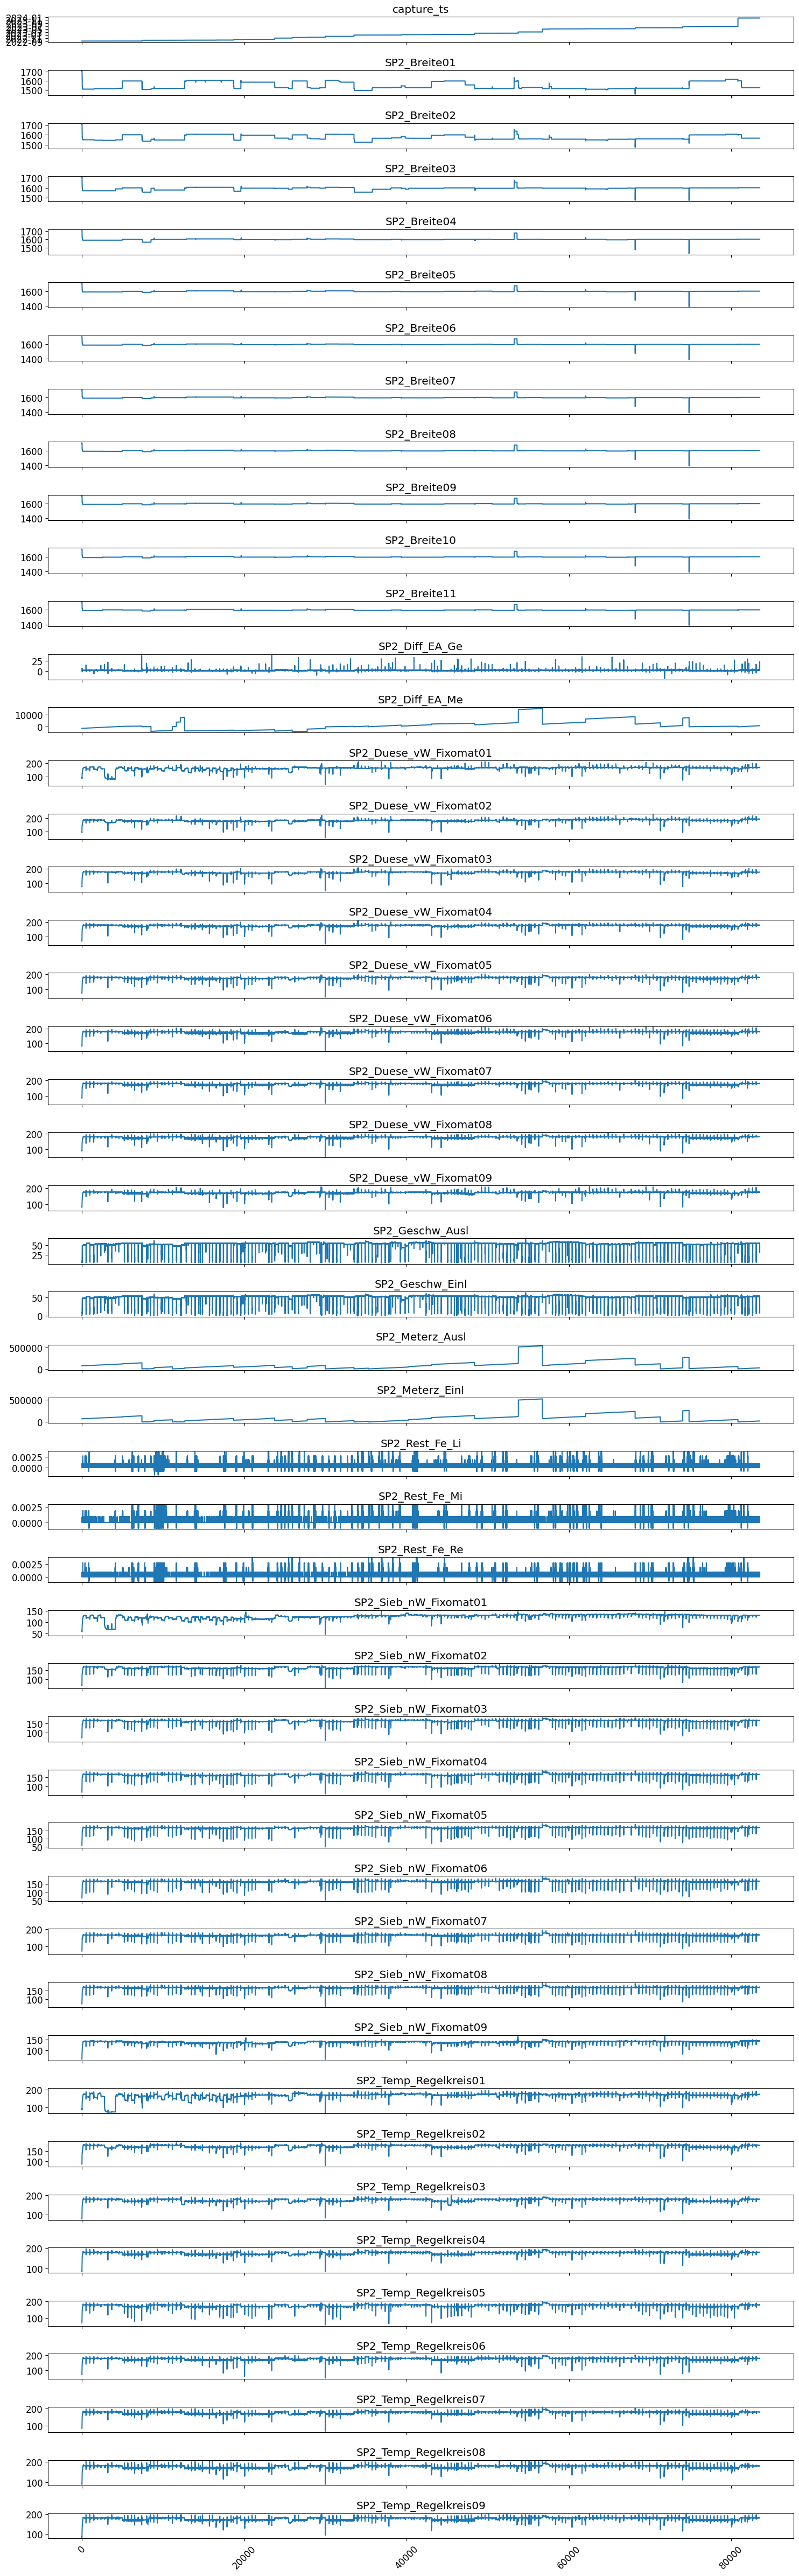

In [27]:
n_plots = df_artikel.shape[1]
fig, axes = plt.subplots(n_plots, 1, figsize=(15, 1*n_plots), sharex=True)


#df_aux = df_cleaned.copy().iloc[1000:2000]
df_aux = df_artikel.copy()

for i, col in enumerate(df_artikel.columns):
    axes[i].plot(df_aux[col])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [26]:
# I am gonna remove the last seconds, when the machine is not moving.
#time_when_stopped = df_artikel.query("SP2_Geschw_Ausl == 0").capture_ts.iloc[0]
#print (time_when_stopped)
#df_artikel = df_artikel[df_artikel["capture_ts"] < time_when_stopped]

print (len(df_artikel))
list_time_stopped = df_artikel.query("SP2_Geschw_Ausl == 0").capture_ts
print (list_time_stopped)
df_artikel = df_artikel[~df_artikel['capture_ts'].isin(list_time_stopped)]
print (len(df_artikel))
df_artikel = df_artikel.reset_index(drop=True)


# remove outliers: 
df_artikel = df_artikel[df_artikel["SP2_Diff_EA_Ge"] < 125]
df_artikel = df_artikel[df_artikel["SP2_Geschw_Ausl"] < 125]
df_artikel = df_artikel[df_artikel["SP2_Geschw_Einl"] < 5000]
print (len(df_artikel))

83515
Series([], Name: capture_ts, dtype: datetime64[ns])
83515
83515


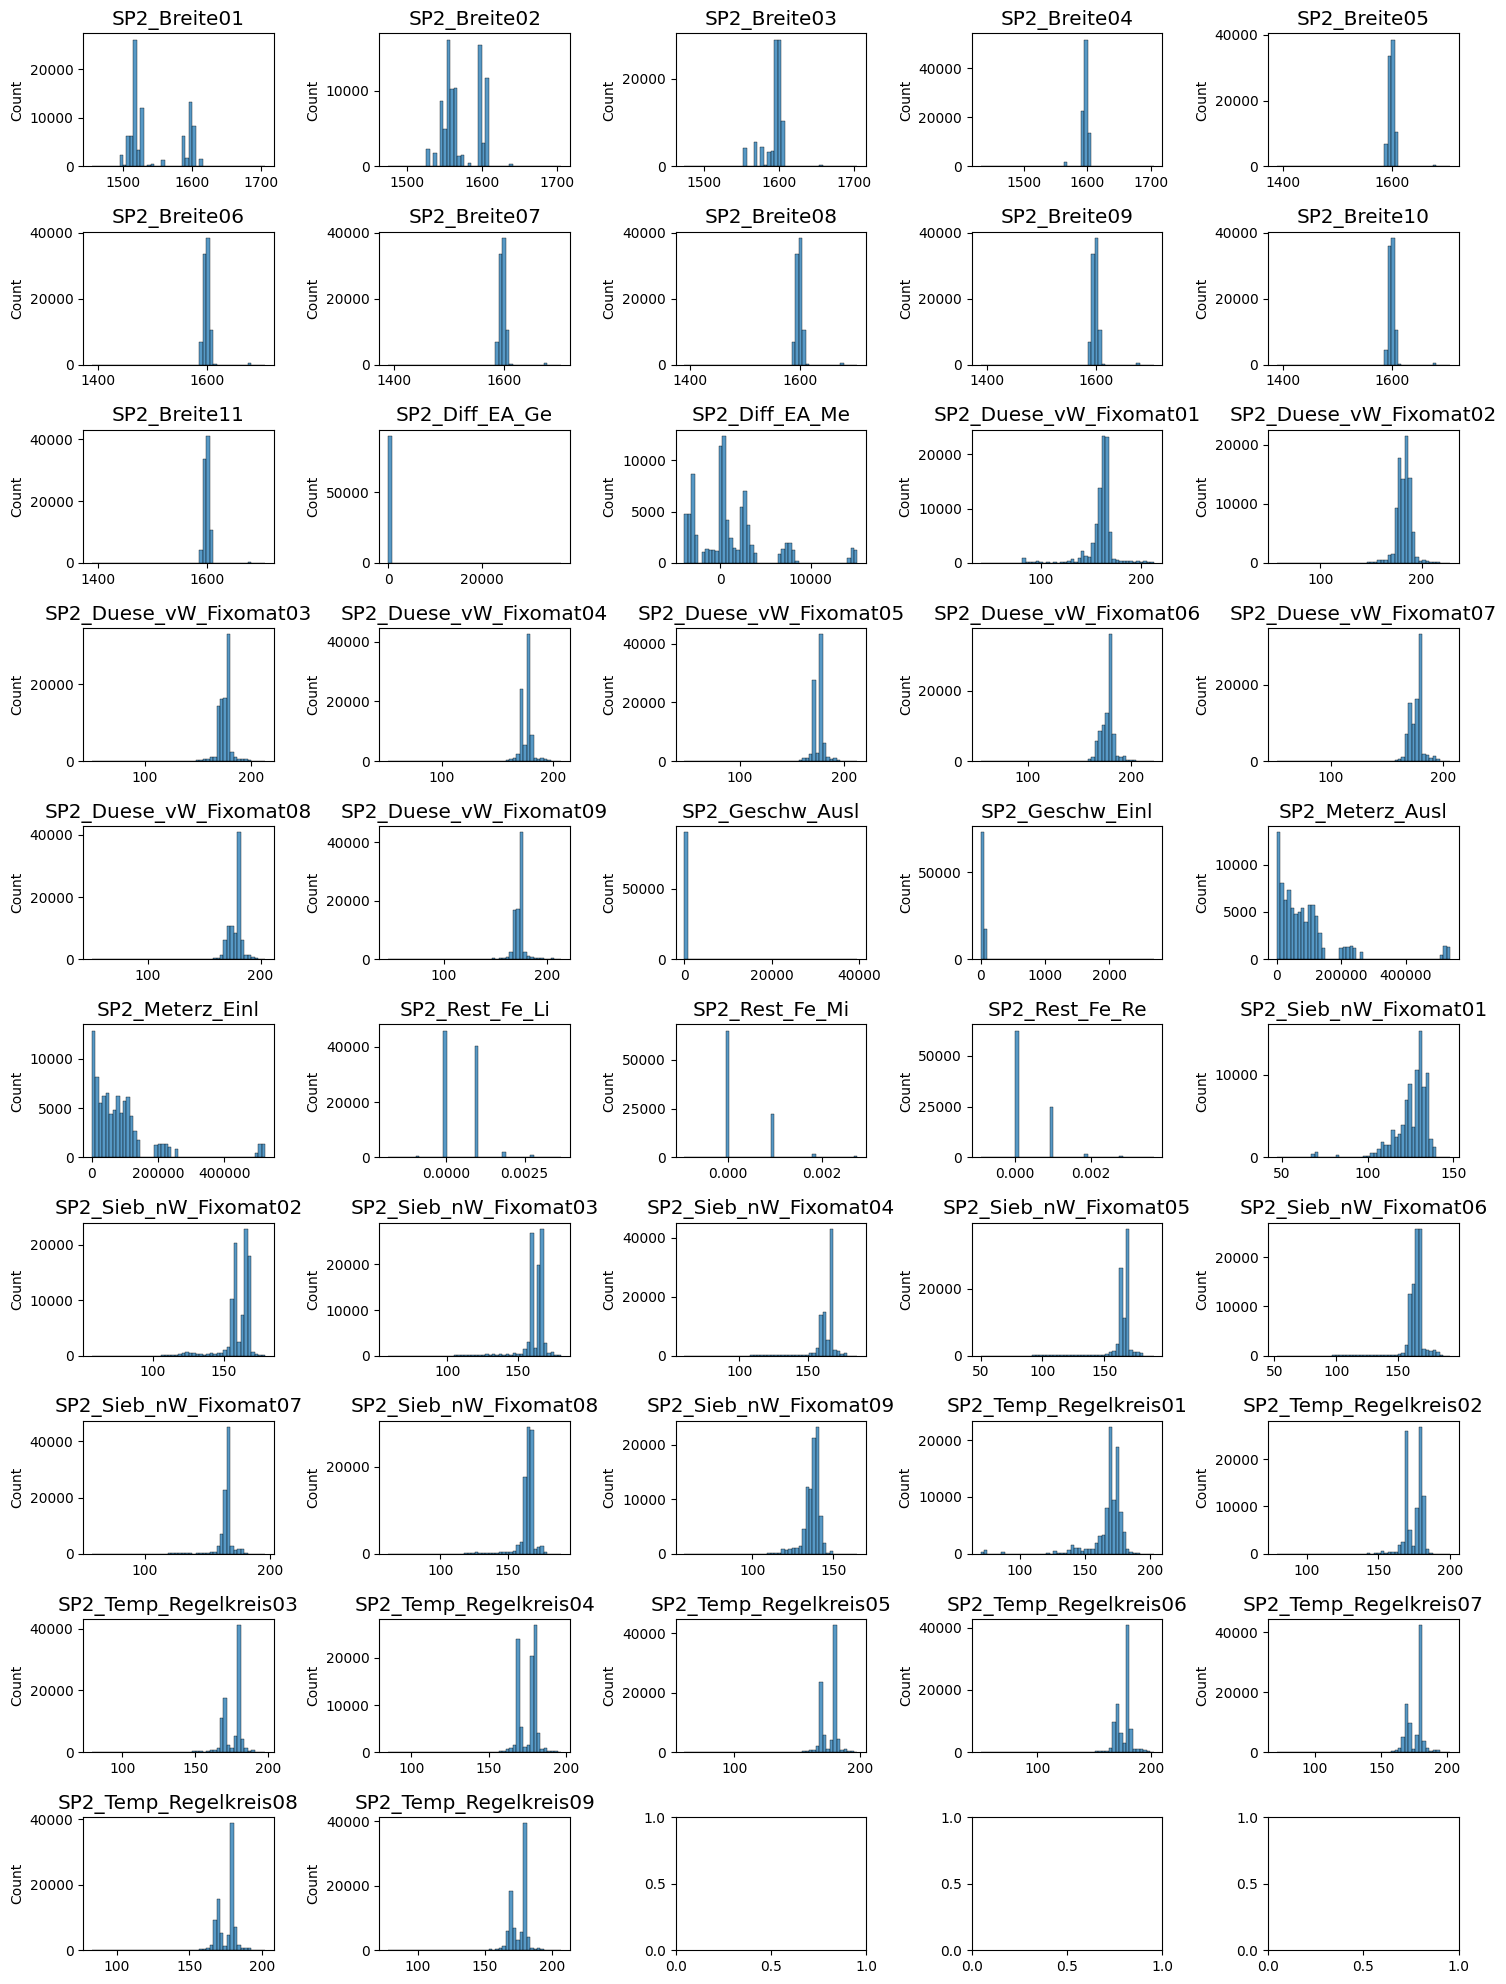

In [23]:
n_cols = 5

float_cols = df_artikel.columns[1:]

n_rows = math.ceil(len(float_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 2*n_rows))
axes = axes.flatten()
plt.rcParams.update({'font.size': 12})

for i, col in enumerate(df_artikel[float_cols]):
    sns.histplot(df_artikel[col], bins=50, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
plt.tight_layout()
plt.show()

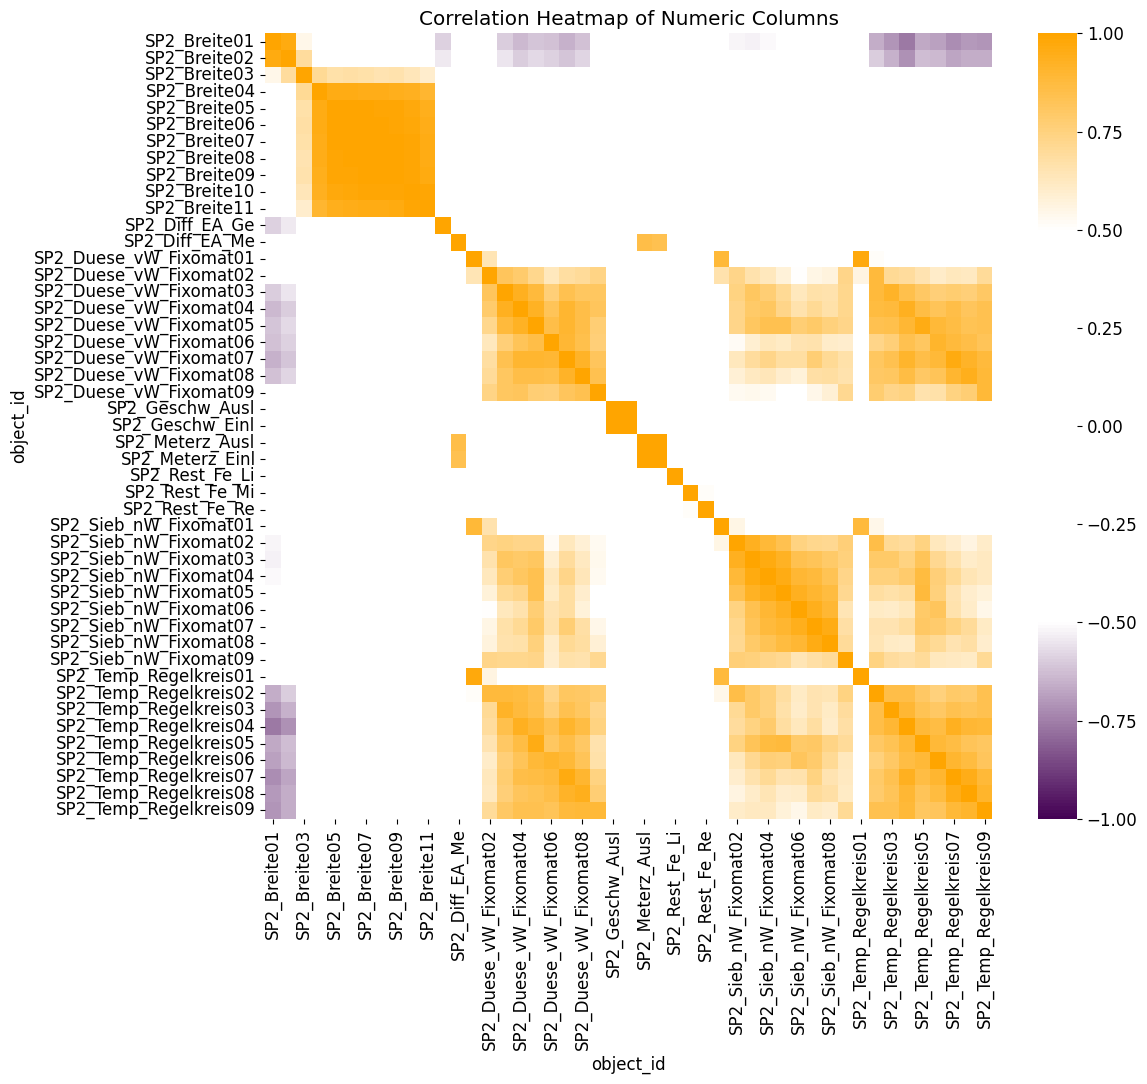

In [28]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

corr_matrix = df_artikel[float_cols].corr()

blue_r = LinearSegmentedColormap.from_list("", ["#440154", "white"])
red = LinearSegmentedColormap.from_list("", ["white", "orange"])

colors = np.vstack((blue_r(np.linspace(0, 1, 128)),
                    np.array([[1,1,1,1]]*255),  # White for the middle range
                    red(np.linspace(0, 1, 128))))
custom_cmap = ListedColormap(colors)

colors = ['#3B4CC0', '#FFFFFF', '#B40426']  # Blue, White, Red
n_bins = 100
cmap = LinearSegmentedColormap.from_list("custom_diverging", colors, N=n_bins)
    
# Create a heatmap
plt.figure(figsize=(12, 11))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap=custom_cmap, vmin=-1, vmax=1, center=0,annot_kws={"size": 8})
plt.title('Correlation Heatmap of Numeric Columns')
plt.tight_layout()
plt.show()

In [37]:
corr_matrix


object_id               SP2_Breite01  SP2_Breite02  SP2_Breite03  \
object_id                                                          
SP2_Breite01                1.000000      0.968676      0.542282   
SP2_Breite02                0.968676      1.000000      0.691640   
SP2_Breite03                0.542282      0.691640      1.000000   
SP2_Breite04                0.388177      0.498517      0.705287   
SP2_Breite05                0.380571      0.485508      0.668929   
SP2_Breite06                0.382957      0.487803      0.672207   
SP2_Breite07                0.384897      0.487326      0.665775   
SP2_Breite08                0.372068      0.475472      0.655145   
SP2_Breite09                0.372540      0.475522      0.657673   
SP2_Breite10                0.366292      0.463178      0.638943   
SP2_Breite11                0.343450      0.432637      0.594800   
SP2_Diff_EA_Ge             -0.586531     -0.543115     -0.225403   
SP2_Diff_EA_Me             -0.353306     -0.326565      0.066060   
SP2_Duese_vW_Fixomat01     -0.074561     -0.008041      0.222158   
SP2_Duese_vW_Fixomat02     -0.473321     -0.410056     -0.028314   
SP2_Duese_vW_Fixomat03     -0.597511     -0.554513     -0.220807   
SP2_Duese_vW_Fixomat04     -0.639249     -0.596870     -0.248016   
SP2_Duese_vW_Fixomat05     -0.612235     -0.572421     -0.245388   
SP2_Duese_vW_Fixomat06     -0.623994     -0.591131     -0.275039   
SP2_Duese_vW_Fixomat07     -0.648764     -0.614780     -0.288402   
SP2_Duese_vW_Fixomat08     -0.621516     -0.581348     -0.231545   
SP2_Duese_vW_Fixomat09     -0.468239     -0.443241     -0.191749   
SP2_Geschw_Ausl            -0.018832     -0.004038      0.065252   
SP2_Geschw_Einl             0.047332      0.057381      0.091507   
SP2_Meterz_Ausl            -0.200073     -0.189722      0.124922   
SP2_Meterz_Einl            -0.192873     -0.183226      0.126488   
SP2_Rest_Fe_Li             -0.024018     -0.012384      0.010636   
SP2_Rest_Fe_Mi              0.000834      0.006425     -0.004563   
SP2_Rest_Fe_Re             -0.006234      0.000847      0.000119   
SP2_Sieb_nW_Fixomat01      -0.202320     -0.128729      0.193934   
SP2_Sieb_nW_Fixomat02      -0.515916     -0.465721     -0.152593   
SP2_Sieb_nW_Fixomat03      -0.524995     -0.483135     -0.191483   
SP2_Sieb_nW_Fixomat04      -0.513507     -0.479119     -0.203220   
SP2_Sieb_nW_Fixomat05      -0.421657     -0.393177     -0.163740   
SP2_Sieb_nW_Fixomat06      -0.378949     -0.353880     -0.147265   
SP2_Sieb_nW_Fixomat07      -0.356584     -0.333509     -0.145598   
SP2_Sieb_nW_Fixomat08      -0.255170     -0.238295     -0.098446   
SP2_Sieb_nW_Fixomat09      -0.452956     -0.415300     -0.130066   
SP2_Temp_Regelkreis01      -0.088118     -0.019317      0.201344   
SP2_Temp_Regelkreis02      -0.663074     -0.599405     -0.190276   
SP2_Temp_Regelkreis03      -0.705019     -0.652901     -0.269136   
SP2_Temp_Regelkreis04      -0.763802     -0.716551     -0.316098   
SP2_Temp_Regelkreis05      -0.669406     -0.628297     -0.278014   
SP2_Temp_Regelkreis06      -0.680292     -0.639957     -0.284961   
SP2_Temp_Regelkreis07      -0.722625     -0.679547     -0.298869   
SP2_Temp_Regelkreis08      -0.698085     -0.656888     -0.289561   
SP2_Temp_Regelkreis09      -0.704378     -0.659365     -0.281515   

object_id               SP2_Breite04  SP2_Breite05  SP2_Breite06  \
object_id                                                          
SP2_Breite01                0.388177      0.380571      0.382957   
SP2_Breite02                0.498517      0.485508      0.487803   
SP2_Breite03                0.705287      0.668929      0.672207   
SP2_Breite04                1.000000      0.957810      0.955611   
SP2_Breite05                0.957810      1.000000      0.996851   
SP2_Breite06                0.955611      0.996851      1.000000   
SP2_Breite07                0.951350      0.994113      0.998429   
SP2_Breite08                0.945416      0.988857     

In [43]:
high_corr_pairs = np.where((corr_matrix > 0.95) & (corr_matrix != 1))
pairs = [(corr_matrix.index[i], corr_matrix.columns[j]) for i, j in zip(*high_corr_pairs)]
for pair in pairs:
    print(f"Pair: {pair}, Correlation: {corr_matrix.loc[pair[0], pair[1]]}")


Pair: ('SP2_Breite01', 'SP2_Breite02'), Correlation: 0.9686763801993014
Pair: ('SP2_Breite02', 'SP2_Breite01'), Correlation: 0.9686763801993014
Pair: ('SP2_Breite04', 'SP2_Breite05'), Correlation: 0.9578100536444542
Pair: ('SP2_Breite04', 'SP2_Breite06'), Correlation: 0.9556111965500951
Pair: ('SP2_Breite04', 'SP2_Breite07'), Correlation: 0.9513500998316612
Pair: ('SP2_Breite05', 'SP2_Breite04'), Correlation: 0.9578100536444542
Pair: ('SP2_Breite05', 'SP2_Breite06'), Correlation: 0.9968508590024598
Pair: ('SP2_Breite05', 'SP2_Breite07'), Correlation: 0.9941134010545708
Pair: ('SP2_Breite05', 'SP2_Breite08'), Correlation: 0.9888571618928205
Pair: ('SP2_Breite05', 'SP2_Breite09'), Correlation: 0.9860043686187344
Pair: ('SP2_Breite05', 'SP2_Breite10'), Correlation: 0.9753725604648698
Pair: ('SP2_Breite06', 'SP2_Breite04'), Correlation: 0.9556111965500951
Pair: ('SP2_Breite06', 'SP2_Breite05'), Correlation: 0.9968508590024598
Pair: ('SP2_Breite06', 'SP2_Breite07'), Correlation: 0.998428741

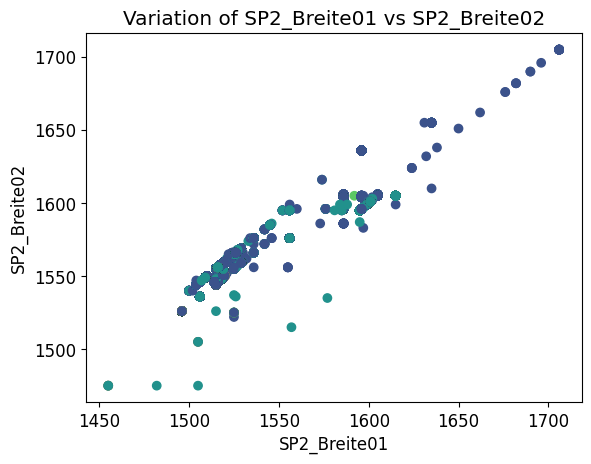

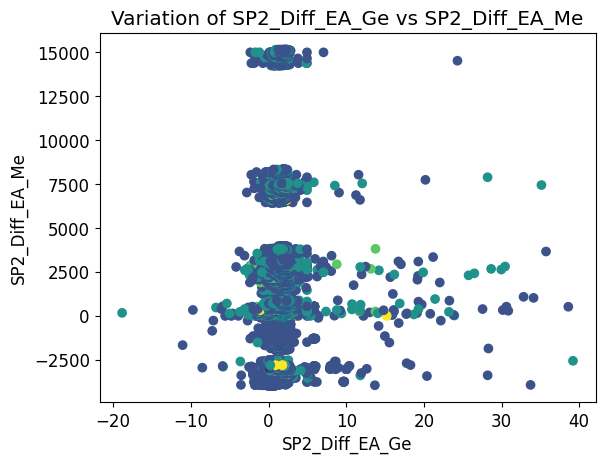

In [34]:
def plot_scatter_variance(label1, label2):
    plt.scatter(df_artikel[label1], df_artikel[label2], c= df_artikel['SP2_Rest_Fe_Mi'])
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.title(f'Variation of {label1} vs {label2}')
    plt.show()

plot_scatter_variance("SP2_Breite01","SP2_Breite02")
plot_scatter_variance("SP2_Diff_EA_Ge","SP2_Diff_EA_Me")

In [29]:
# Feature importance, but only gor regression
from sklearn.feature_selection import mutual_info_regression

def mutual_info_score(series,target):
    return mutual_info_regression(series.values.reshape(-1, 1), df_artikel[target])[0] # as example


In [35]:


mi = df_artikel[float_cols].apply(mutual_info_score,target="SP2_Rest_Fe_Mi")
mi = mi.sort_values(ascending=False)
print(mi)

object_id
SP2_Rest_Fe_Mi            0.715889
SP2_Rest_Fe_Re            0.124446
SP2_Diff_EA_Me            0.089814
SP2_Rest_Fe_Li            0.073784
SP2_Breite02              0.060643
SP2_Breite01              0.054140
SP2_Breite07              0.051670
SP2_Breite03              0.049983
SP2_Breite08              0.048185
SP2_Breite06              0.047251
SP2_Breite04              0.041854
SP2_Breite10              0.039709
SP2_Breite09              0.038744
SP2_Sieb_nW_Fixomat01     0.037378
SP2_Breite05              0.035356
SP2_Meterz_Einl           0.034955
SP2_Diff_EA_Ge            0.032617
SP2_Meterz_Ausl           0.032118
SP2_Breite11              0.029664
SP2_Temp_Regelkreis01     0.018234
SP2_Duese_vW_Fixomat01    0.017465
SP2_Geschw_Ausl           0.017061
SP2_Duese_vW_Fixomat02    0.015210
SP2_Geschw_Einl           0.011391
SP2_Duese_vW_Fixomat03    0.011111
SP2_Duese_vW_Fixomat08    0.009648
SP2_Sieb_nW_Fixomat07     0.008351
SP2_Temp_Regelkreis03     0.008144
SP2_Sieb_n

In [45]:
print (df_artikel.columns)

Index(['capture_ts', 'SP2_Breite01', 'SP2_Breite02', 'SP2_Breite03',
       'SP2_Breite04', 'SP2_Breite05', 'SP2_Breite06', 'SP2_Breite07',
       'SP2_Breite08', 'SP2_Breite09', 'SP2_Breite10', 'SP2_Breite11',
       'SP2_Diff_EA_Ge', 'SP2_Diff_EA_Me', 'SP2_Duese_vW_Fixomat01',
       'SP2_Duese_vW_Fixomat02', 'SP2_Duese_vW_Fixomat03',
       'SP2_Duese_vW_Fixomat04', 'SP2_Duese_vW_Fixomat05',
       'SP2_Duese_vW_Fixomat06', 'SP2_Duese_vW_Fixomat07',
       'SP2_Duese_vW_Fixomat08', 'SP2_Duese_vW_Fixomat09', 'SP2_Geschw_Ausl',
       'SP2_Geschw_Einl', 'SP2_Meterz_Ausl', 'SP2_Meterz_Einl',
       'SP2_Rest_Fe_Li', 'SP2_Rest_Fe_Mi', 'SP2_Rest_Fe_Re',
       'SP2_Sieb_nW_Fixomat01', 'SP2_Sieb_nW_Fixomat02',
       'SP2_Sieb_nW_Fixomat03', 'SP2_Sieb_nW_Fixomat04',
       'SP2_Sieb_nW_Fixomat05', 'SP2_Sieb_nW_Fixomat06',
       'SP2_Sieb_nW_Fixomat07', 'SP2_Sieb_nW_Fixomat08',
       'SP2_Sieb_nW_Fixomat09', 'SP2_Temp_Regelkreis01',
       'SP2_Temp_Regelkreis02', 'SP2_Temp_Regelkreis03'

In [46]:
df_artikel = df_artikel.drop("SP2_Meterz_Ausl",axis=1)
df_artikel = df_artikel.drop("SP2_Geschw_Ausl",axis=1)
df_artikel = df_artikel.drop("SP2_Diff_EA_Ge",axis=1)
df_artikel = df_artikel.drop("SP2_Diff_EA_Me",axis=1)

import re
r = re.compile(".*Breite.*")
remove_list = list(filter(r.match, df_artikel.columns.values.tolist())) 
print(remove_list)
df_artikel = df_artikel.drop(remove_list,axis=1)


['SP2_Breite01', 'SP2_Breite02', 'SP2_Breite03', 'SP2_Breite04', 'SP2_Breite05', 'SP2_Breite06', 'SP2_Breite07', 'SP2_Breite08', 'SP2_Breite09', 'SP2_Breite10', 'SP2_Breite11']


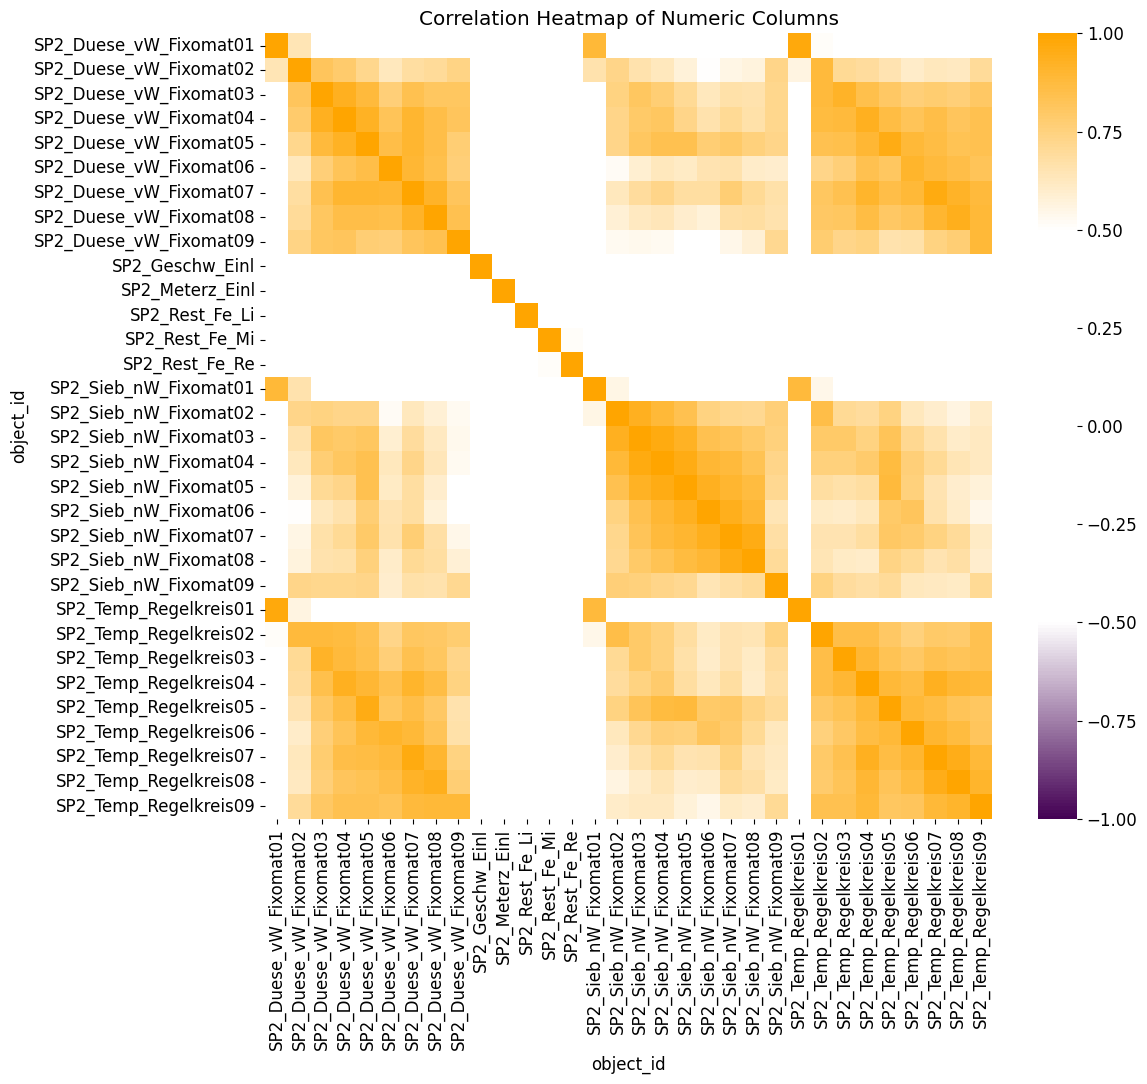

In [48]:
corr_matrix = df_artikel[df_artikel.columns[1:]].corr()

blue_r = LinearSegmentedColormap.from_list("", ["#440154", "white"])
red = LinearSegmentedColormap.from_list("", ["white", "orange"])

colors = np.vstack((blue_r(np.linspace(0, 1, 128)),
                    np.array([[1,1,1,1]]*255),  # White for the middle range
                    red(np.linspace(0, 1, 128))))
custom_cmap = ListedColormap(colors)

colors = ['#3B4CC0', '#FFFFFF', '#B40426']  # Blue, White, Red
n_bins = 100
cmap = LinearSegmentedColormap.from_list("custom_diverging", colors, N=n_bins)
    
# Create a heatmap
plt.figure(figsize=(12, 11))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap=custom_cmap, vmin=-1, vmax=1, center=0,annot_kws={"size": 8})
plt.title('Correlation Heatmap of Numeric Columns')
plt.tight_layout()
plt.show()

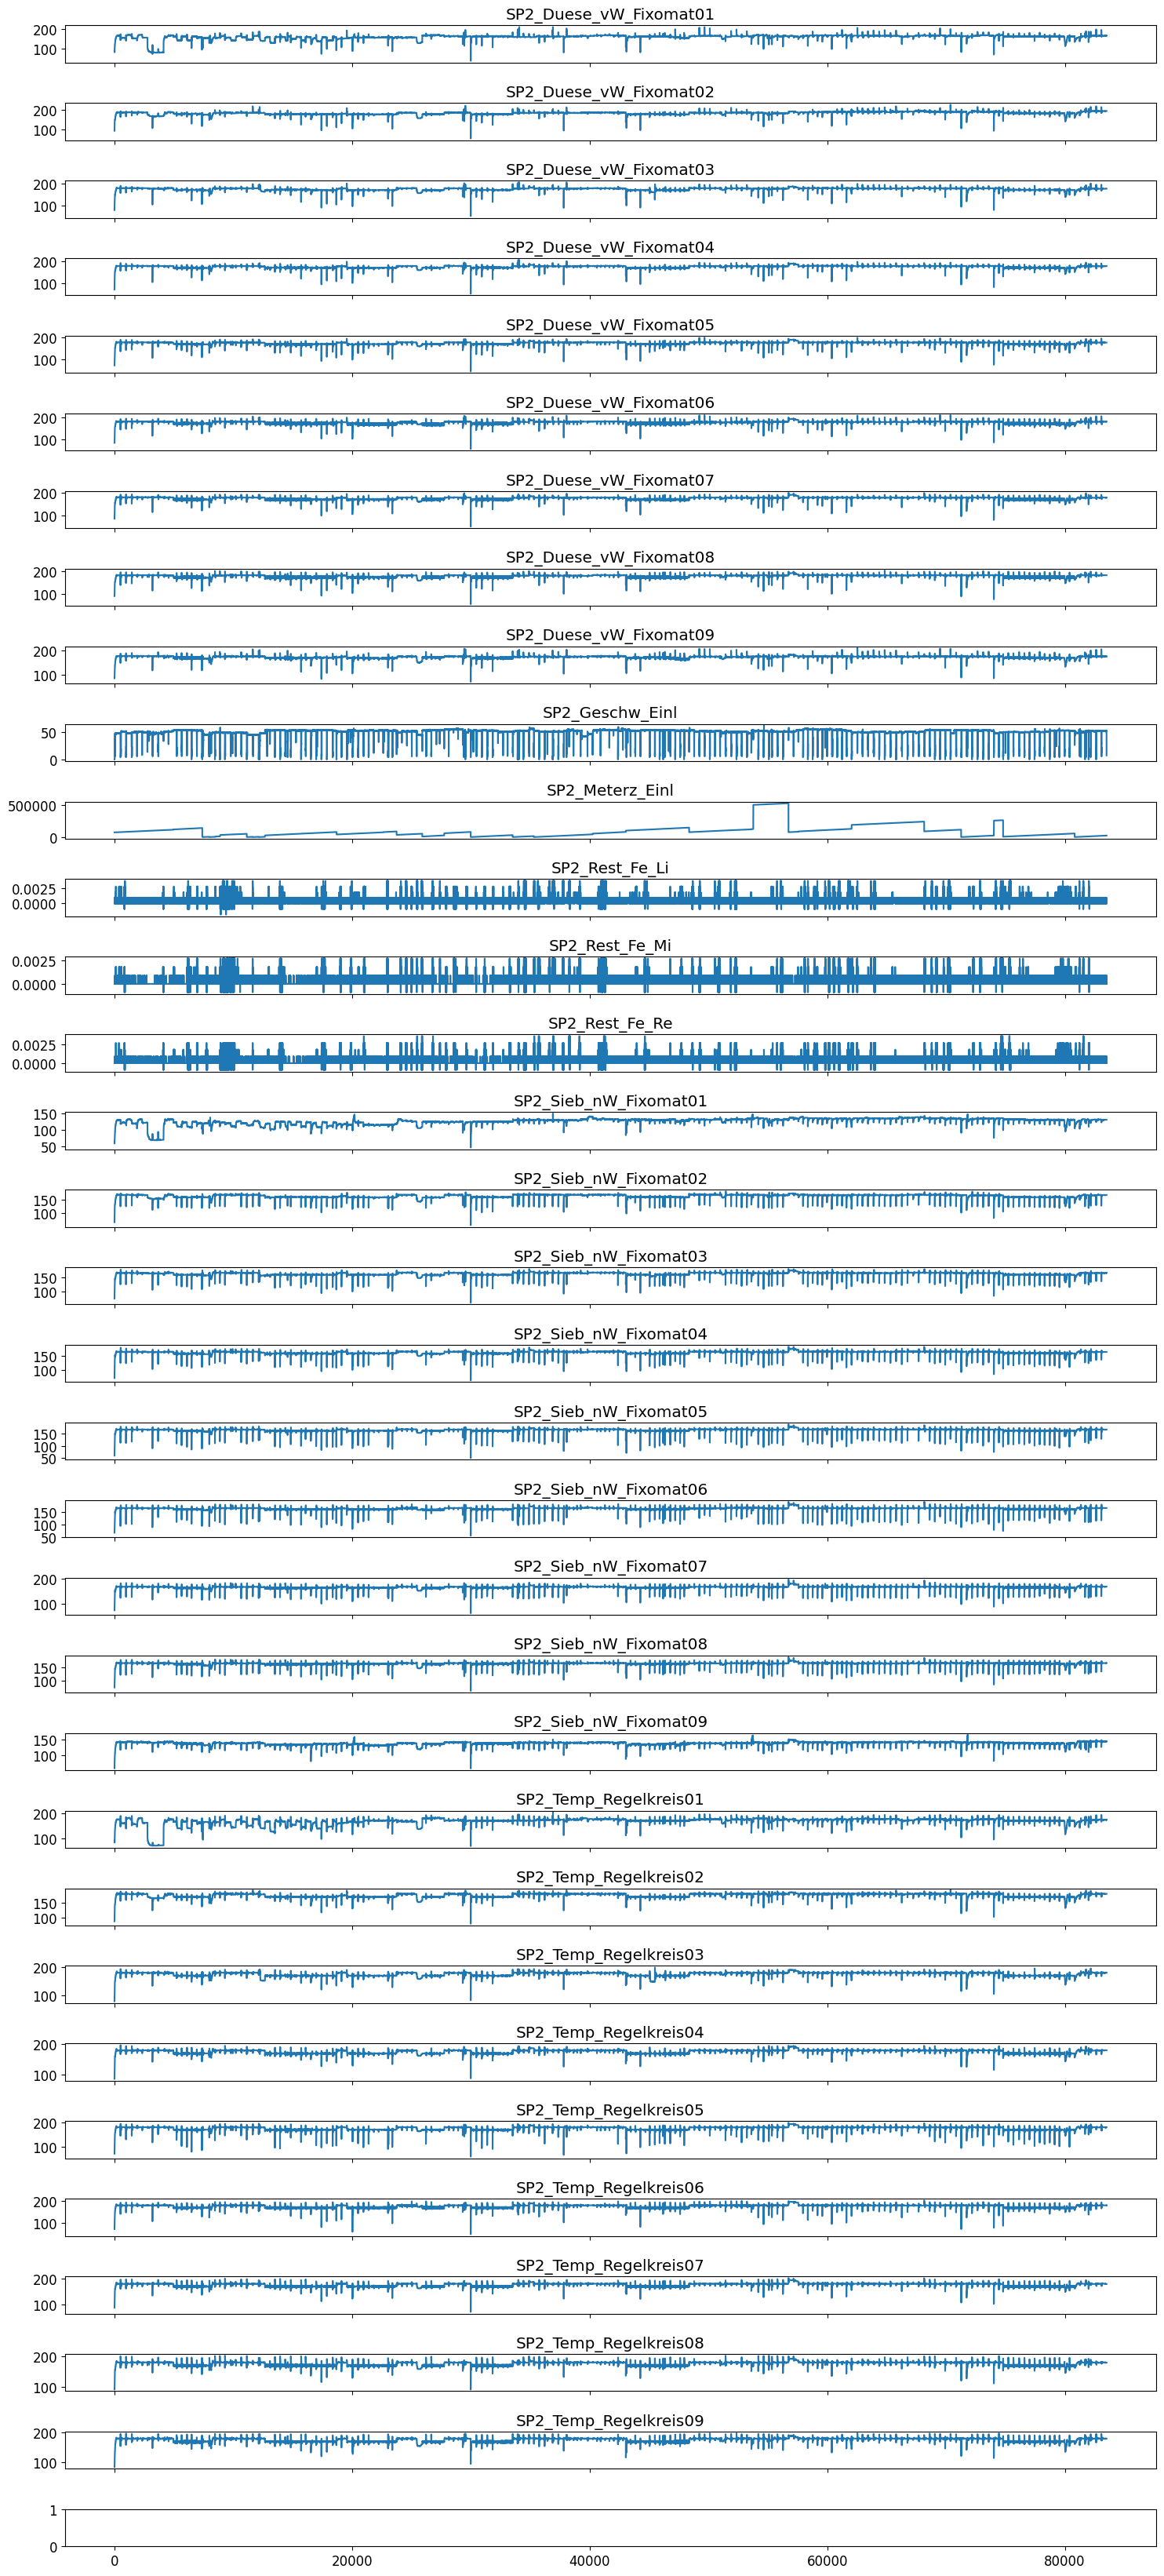

In [49]:
n_plots = df_artikel.shape[1]
fig, axes = plt.subplots(n_plots, 1, figsize=(15, 1*n_plots), sharex=True)


#df_aux = df_cleaned.copy().iloc[1000:2000]
df_aux = df_artikel.copy()

for i, col in enumerate(df_artikel.columns[1:]):
    axes[i].plot(df_aux[col])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Many of the variables are not informative. I will apply a cutoff at 0.05 score and train with those.

In [16]:
cutoff = 0.05
variables = []
for target in ["SP2_Rest_Fe_Li","SP2_Rest_Fe_Mi","SP2_Rest_Fe_Re"]:
    v = df_artikel[float_cols].apply(mutual_info_score,target=target)
    vs = v[v > cutoff].index
    variables.extend(vs)

final_cols = list(set((variables)))
print (final_cols)

['SP2_Duese_vW_Fixomat06', 'SP2_Geschw_Ausl', 'SP2_Rest_Fe_Mi', 'SP2_Diff_EA_Me', 'SP2_Duese_vW_Fixomat02', 'SP2_Sieb_nW_Fixomat01', 'SP2_Temp_Regelkreis01', 'SP2_Temp_Regelkreis02', 'SP2_Duese_vW_Fixomat01', 'SP2_Duese_vW_Fixomat03', 'SP2_Geschw_Einl', 'SP2_Sieb_nW_Fixomat02', 'SP2_Meterz_Einl', 'SP2_Temp_Regelkreis07', 'SP2_Duese_vW_Fixomat07', 'SP2_Rest_Fe_Li', 'SP2_Meterz_Ausl', 'SP2_Rest_Fe_Re']


<Figure size 1000x4000 with 0 Axes>

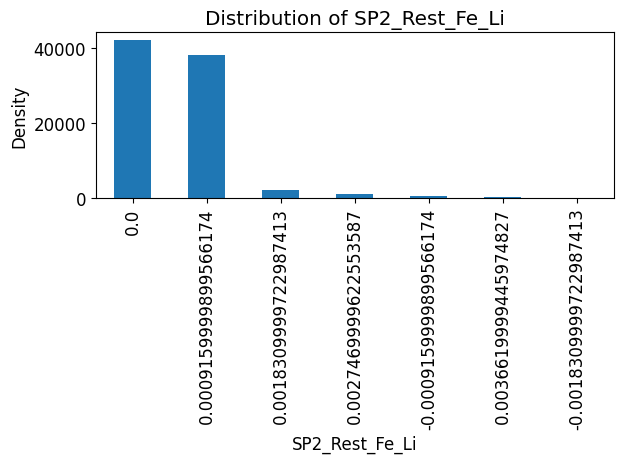

In [31]:
plt.figure(figsize=(10,40))
plt.figure()
df_artikel["SP2_Rest_Fe_Li"].value_counts().plot(kind = 'bar')
x_name = "SP2_Rest_Fe_Li"
y_name = 'Density'
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title('Distribution of {x_name}'.format(x_name=x_name))
plt.tight_layout()

Build and train model


In [50]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Attention, Input
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adadelta, Adagrad, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

2024-11-15 00:07:44.025598: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-15 00:07:44.214199: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-15 00:07:44.359709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731625664.496175   21180 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731625664.534574   21180 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 00:07:45.070917: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [52]:
final_cols = df_artikel.columns[1:]
target_columns = ['SP2_Rest_Fe_Li', 'SP2_Rest_Fe_Mi', 'SP2_Rest_Fe_Re']
feature_columns = [f for f in final_cols if f not in target_columns]
all_features = feature_columns+target_columns

df_aux = df_artikel[all_features]
target_indices = [df_aux.columns.get_loc(col) for col in target_columns]
print (target_indices)

data = df_aux.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences to give temporal context to the model
def create_sequences(data, seq_length, target_indices):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, target_indices]) 
    return np.array(X), np.array(y)

seq_length = 5  # window size

X, y = create_sequences(scaled_data, seq_length, target_indices)

print(X.shape, y.shape)

# 80, 20, 20 @ train, validation, test.
# data is sequential, so no shuffling.

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=False)

print(X_train.shape, X_val.shape, X_test.shape)
print(len(df_aux))

## Inverse transform for multiple targets
#def inverse_transform_targets(y, target_indices, scaler, features):
#    y_actual = []
#    for i in range(y.shape[1]):
#        y_actual.append(scaler.inverse_transform(np.column_stack(
#            (np.zeros((len(y), target_indices[i])), 
#             y[:, i].reshape(-1, 1), 
#             np.zeros((len(y), len(features) - target_indices[i] - 1)))
#        ))[:, target_indices[i]])
#    return np.array(y_actual).T
#
#y_train_actual = inverse_transform_targets(y_train, target_indices, scaler, feature_columns)
#y_train_full_actual = inverse_transform_targets(y_train_full, target_indices, scaler, feature_columns)
#y_val_actual = inverse_transform_targets(y_val, target_indices, scaler, feature_columns)
#y_test_actual = inverse_transform_targets(y_test, target_indices, scaler, feature_columns)
#
## Plot the target variables to see how much we use for training, validation, and test.
#continuous_values = range(len(np.concatenate((y_train_actual.flatten(), y_val_actual.flatten(), y_test_actual.flatten()))))
#
#fig, ax = plt.subplots(figsize=(8, 2))
#for i, target in enumerate(target_columns):
#    ax.plot(continuous_values[0:len(y_train_actual)], y_train_actual[:, i], label=f'Train {target}')
#    ax.plot(continuous_values[len(y_train_actual):len(y_train_actual) + len(y_val_actual)], y_val_actual[:, i], label=f'Validation {target}')
#    ax.plot(continuous_values[len(y_train_actual) + len(y_val_actual):], y_test_actual[:, i], label=f'Test {target}')
#ax.legend()
#plt.show()


[29, 30, 31]
(83510, 5, 32) (83510, 3)
(50106, 5, 32) (16702, 5, 32) (16702, 5, 32)
83515


We have very few samples... Let's try a very small LSTM model.

In [53]:
inputs = keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = layers.LSTM(16, recurrent_dropout=0.1,activation="relu")(inputs)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(target_columns))(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='textiles_lstm_test.keras',
                                   monitor='val_loss',
                                   save_best_only=True)
    ]

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.summary()
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, validation_data=(X_val, y_val), callbacks=callbacks)



2024-11-15 00:08:42.304693: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,187 (12.45 KB)

 Trainable params: 3,187 (12.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1566/1566 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1055 - mae: 0.1844 - val_loss: 0.0122 - val_mae: 0.0836
Epoch 2/100
1566/1566 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0125 - mae: 0.0819 - val_loss: 0.0120 - val_mae: 0.0852
Epoch 3/100
1566/1566 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0116 - mae: 0.0793 - val_loss: 0.0123 - val_mae: 0.0810
Epoch 4/100
1566/1566 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0115 - mae: 0.0789 - val_loss: 0.0121 - val_mae: 0.0805
Epoch 5/100
1566/1566 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0114 - mae: 0.0774 - val_loss: 0.0119 - val_mae: 0.0815
Epoch 6/100
1566/1566 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0113 - mae: 0.0768 - val_loss: 0.0118 - val_mae: 0.0854
Epoch 7/100
1566/1566 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0113 - mae: 0.0768 - val_loss: 0.0118 - val_mae: 0.0835
Epoch 8/100
1566/1566 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0114 - mae: 0.0773 - val_loss: 0.0118 - val_mae: 0.0842
Epoch 9/100
1566/1566 ━━━━━━━━━━

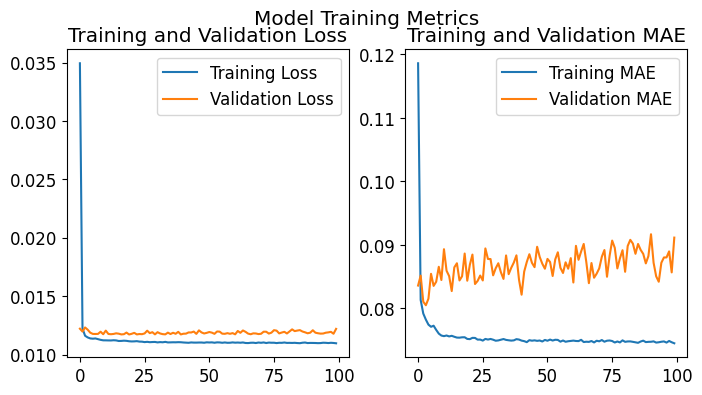

Best val loss: 0.011717722751200199


In [54]:
def validation_metrics_plot(history, title):
    fig = plt.figure(figsize=(8, 4))
    
    # Plot Training and Validation Loss
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.legend()
    ax1.set_title('Training and Validation Loss')
    
    # Plot Training and Validation MAE
    if 'mae' in history.history and 'val_mae' in history.history:
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.plot(history.history['mae'], label='Training MAE')
        ax2.plot(history.history['val_mae'], label='Validation MAE')
        ax2.legend()
        ax2.set_title('Training and Validation MAE')
    
    plt.suptitle(title)
    plt.show()
    
    # Print the best validation loss
    print("Best val loss: {}".format(min(history.history["val_loss"])))

validation_metrics_plot(history, "Model Training Metrics")

522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step

Metrics for SP2_Rest_Fe_Li:
MSE: 0.0000
RMSE: 0.0005
MAE: 0.0004
R2 Score: 0.0663
MAPE: inf%

Metrics for SP2_Rest_Fe_Mi:
MSE: 0.0000
RMSE: 0.0005
MAE: 0.0004
R2 Score: 0.1100
MAPE: inf%

Metrics for SP2_Rest_Fe_Re:
MSE: 0.0000
RMSE: 0.0005
MAE: 0.0004
R2 Score: 0.0983
MAPE: inf%


/tmp/ipykernel_21180/3626170324.py:34: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100
/tmp/ipykernel_21180/3626170324.py:34: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100
/tmp/ipykernel_21180/3626170324.py:34: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100


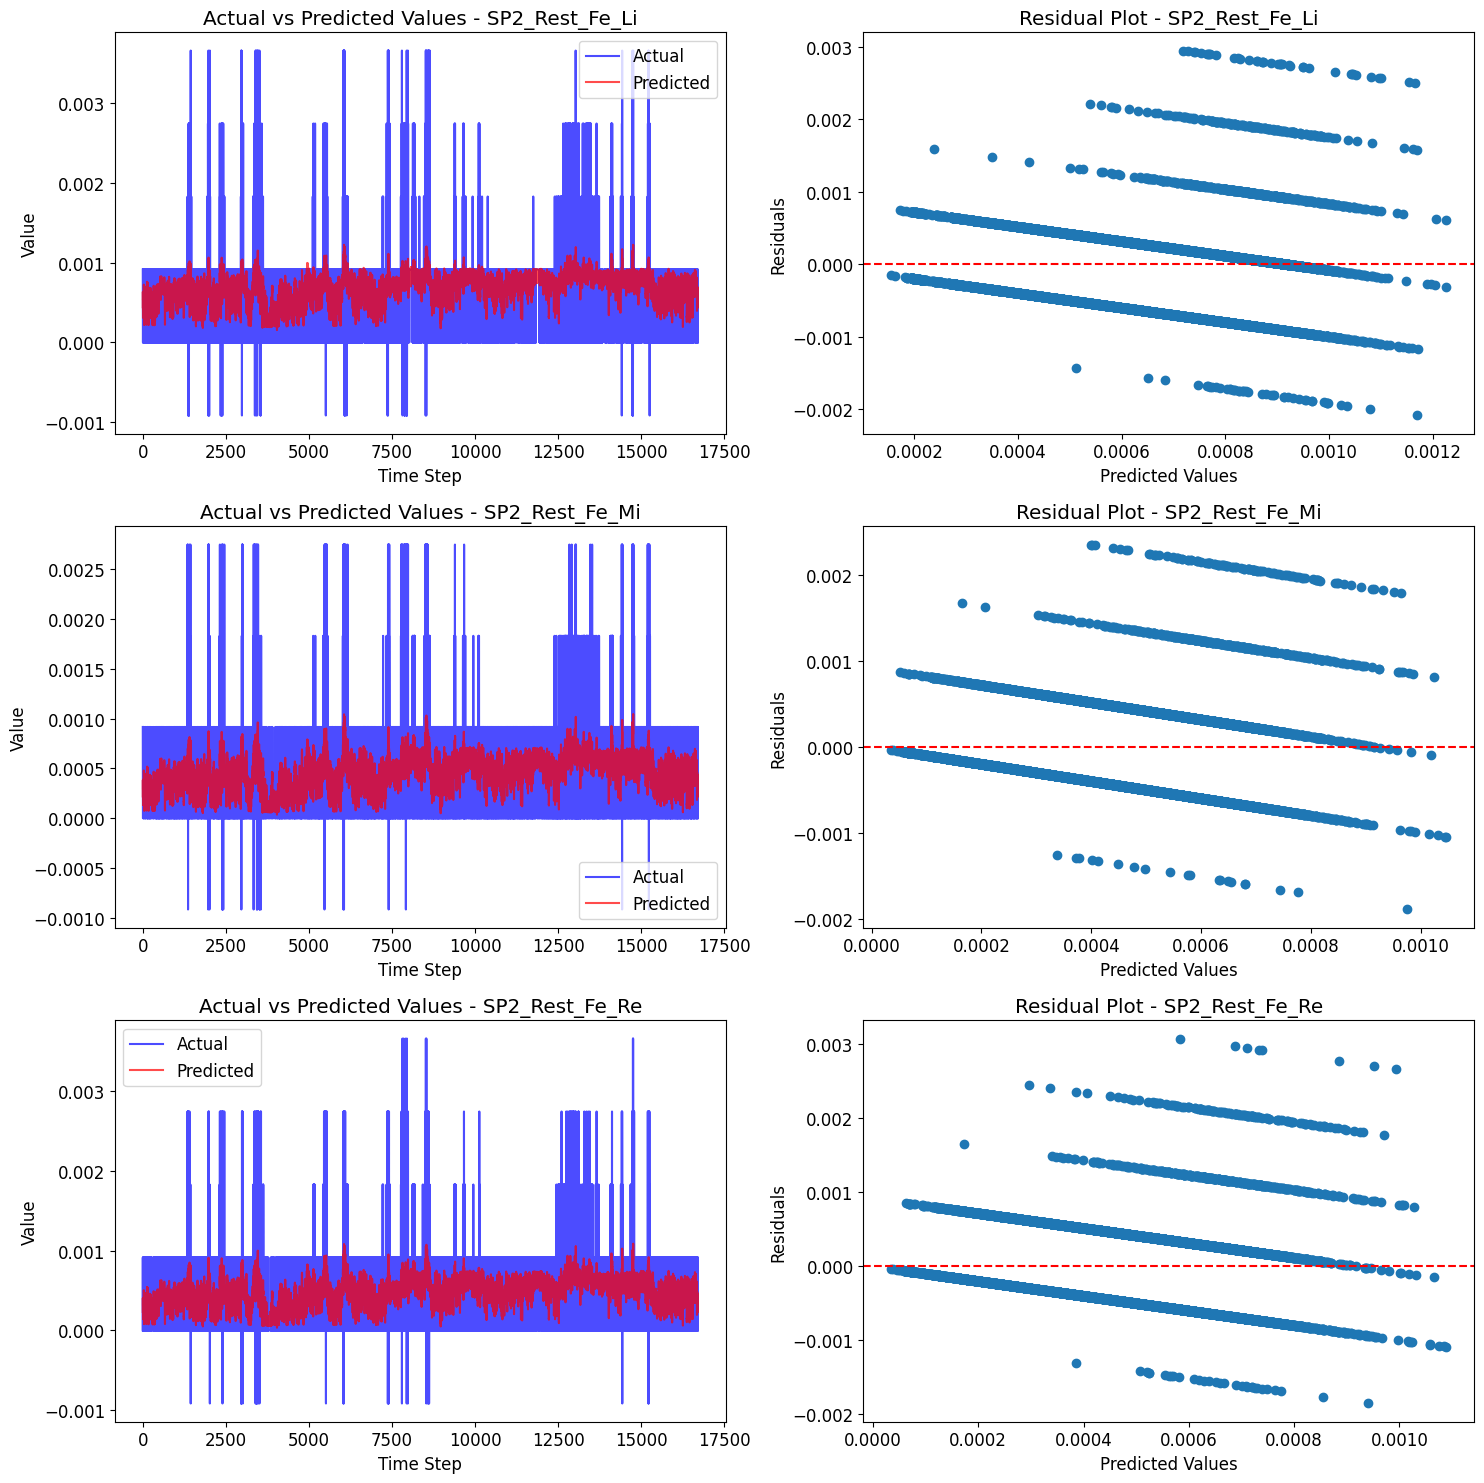

In [55]:
def evaluate_and_predict(model, X_test, y_test, target_columns, scaler, features):
    
    predictions = model.predict(X_test)
    
    results = {}
    
    for i, target in enumerate(target_columns):
        print(f"\nMetrics for {target}:")
        
        target_index = features.index(target)
        
        # Get predictions and actual values for current target
        current_predictions = predictions[:, i]
        current_y_test = y_test[:, i]
        
        # Inverse transform
        predictions_actual = scaler.inverse_transform(np.column_stack((
            np.zeros((len(current_predictions), target_index)),
            current_predictions.reshape(-1, 1),
            np.zeros((len(current_predictions), len(features)-target_index-1))
        )))[:, target_index]
        
        y_test_actual = scaler.inverse_transform(np.column_stack((
            np.zeros((len(current_y_test), target_index)),
            current_y_test.reshape(-1, 1),
            np.zeros((len(current_y_test), len(features)-target_index-1))
        )))[:, target_index]
        
        # Calculate metrics
        mse = mean_squared_error(y_test_actual, predictions_actual)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_actual, predictions_actual)
        r2 = r2_score(y_test_actual, predictions_actual)
        mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100
        
        # Store results
        results[target] = {
            'predictions': predictions_actual,
            'actual': y_test_actual,
            'metrics': {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2,
                'MAPE': mape
            }
        }
        
        # Print metrics
        print(f'MSE: {mse:.4f}')
        print(f'RMSE: {rmse:.4f}')
        print(f'MAE: {mae:.4f}')
        print(f'R2 Score: {r2:.4f}')
        print(f'MAPE: {mape:.4f}%')
    
    # Create plots
    fig, axes = plt.subplots(len(target_columns), 2, figsize=(15, 5*len(target_columns)))
    
    for i, target in enumerate(target_columns):
        # Get data for current target
        y_test_actual = results[target]['actual']
        predictions_actual = results[target]['predictions']
        
        # Sort for plotting
        sorted_indices = np.argsort(y_test_actual)
        y_test_sorted = y_test_actual[sorted_indices]
        predictions_sorted = predictions_actual[sorted_indices]
        
        axes[i,0].plot(y_test_actual, label='Actual', color='blue', alpha=0.7)
        axes[i,0].plot(predictions_actual, label='Predicted', color='red', alpha=0.7)
        axes[i,0].set_title(f'Actual vs Predicted Values - {target}')
        axes[i,0].set_xlabel('Time Step')
        axes[i,0].set_ylabel('Value')
        axes[i,0].legend()
        
        residuals = y_test_actual - predictions_actual
        axes[i,1].scatter(predictions_actual, residuals)
        axes[i,1].axhline(y=0, color='r', linestyle='--')
        axes[i,1].set_xlabel('Predicted Values')
        axes[i,1].set_ylabel('Residuals')
        axes[i,1].set_title(f'Residual Plot - {target}')
    
    plt.tight_layout()
    plt.savefig("figures/evaluation_test.pdf", dpi=300)
    plt.show()
    
    return results

results = evaluate_and_predict(model, X_test, y_test, 
                              target_columns=target_columns, 
                              scaler=scaler, 
                              features=all_features)

Horrible predictions. 

[-0.001831 -0.000916  0.        0.000916  0.001831  0.002747  0.003662]


/tmp/ipykernel_21180/1950732267.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


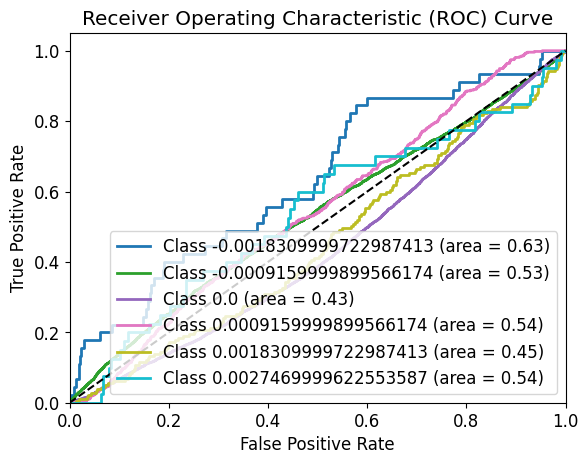

Accuracy: 0.5634

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        45
           2       0.38      0.49      0.43      5238
           3       0.69      0.64      0.66     10728
           4       0.00      0.00      0.00       473
           5       0.00      0.00      0.00       175
           6       0.00      0.00      0.00        40

    accuracy                           0.56     16699
   macro avg       0.18      0.19      0.18     16699
weighted avg       0.56      0.56      0.56     16699



/home/ibai/.local/share/virtualenvs/textile-RlY57q6n/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibai/.local/share/virtualenvs/textile-RlY57q6n/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibai/.local/share/virtualenvs/textile-RlY57q6n/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [73]:
# Let's try a XGBoost classifier

import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize

final_cols = df_artikel.columns[1:]
target_column = 'SP2_Rest_Fe_Li'  #Start with 1
feature_columns = [f for f in final_cols if f not in target_columns] # remove all 3 targets
all_features = feature_columns + [target_column]

df_aux = df_artikel[all_features]
target_index = df_aux.columns.get_loc(target_column)

data = df_aux.values

data_features = df_aux[feature_columns].values
data_target = df_aux[target_column].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_features)

# Create sequences
def create_sequences(features, target, seq_length):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:(i + seq_length), :])
        y.append(target[i + seq_length]) 
    return np.array(X), np.array(y)

seq_length = 20  # window size

X, y = create_sequences(scaled_data, target, seq_length)

print (np.unique(y))

# Convert target to categorical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_labels = label_encoder.classes_ 


# Split the data
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y_encoded, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=False)

# Reshape X for XGBoost (flatten the sequence dimension)
n_samples, seq_len, n_features = X_train.shape
X_train = X_train.reshape(n_samples, seq_len * n_features)
X_val = X_val.reshape(X_val.shape[0], seq_len * n_features)
X_test = X_test.reshape(X_test.shape[0], seq_len * n_features)

model = xgb.XGBClassifier(n_estimators=100,random_state=42)

model.fit(X_train, y_train)

val_predictions = model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)

# Make predictions on the test set
test_predictions = model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

# Get probability predictions for ROC curve
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]
y_score = model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
#for i in range(n_classes):
#    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} ROC curve (area = {roc_auc[i]:0.2f})')
colors = plt.cm.get_cmap('tab10', n_classes)

for i, color in zip(range(n_classes), colors.colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {class_labels[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")
plt.show()

# Make predictions
test_predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, test_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, test_predictions))




Training model for SP2_Rest_Fe_Li
[0]	validation_0-rmse:0.00072	validation_1-rmse:0.00080
[1]	validation_0-rmse:0.00071	validation_1-rmse:0.00079
[2]	validation_0-rmse:0.00070	validation_1-rmse:0.00079
[3]	validation_0-rmse:0.00069	validation_1-rmse:0.00078
[4]	validation_0-rmse:0.00068	validation_1-rmse:0.00078
[5]	validation_0-rmse:0.00068	validation_1-rmse:0.00078
[6]	validation_0-rmse:0.00067	validation_1-rmse:0.00078
[7]	validation_0-rmse:0.00066	validation_1-rmse:0.00078
[8]	validation_0-rmse:0.00066	validation_1-rmse:0.00078
[9]	validation_0-rmse:0.00066	validation_1-rmse:0.00078
[10]	validation_0-rmse:0.00065	validation_1-rmse:0.00078
[11]	validation_0-rmse:0.00065	validation_1-rmse:0.00078
[12]	validation_0-rmse:0.00064	validation_1-rmse:0.00078
[13]	validation_0-rmse:0.00064	validation_1-rmse:0.00078
[14]	validation_0-rmse:0.00064	validation_1-rmse:0.00077
[15]	validation_0-rmse:0.00063	validation_1-rmse:0.00078
[16]	validation_0-rmse:0.00063	validation_1-rmse:0.00078
[17]	v

<Figure size 1000x600 with 0 Axes>

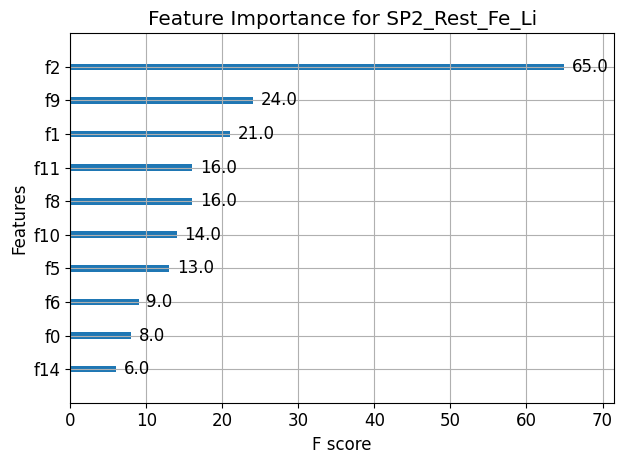

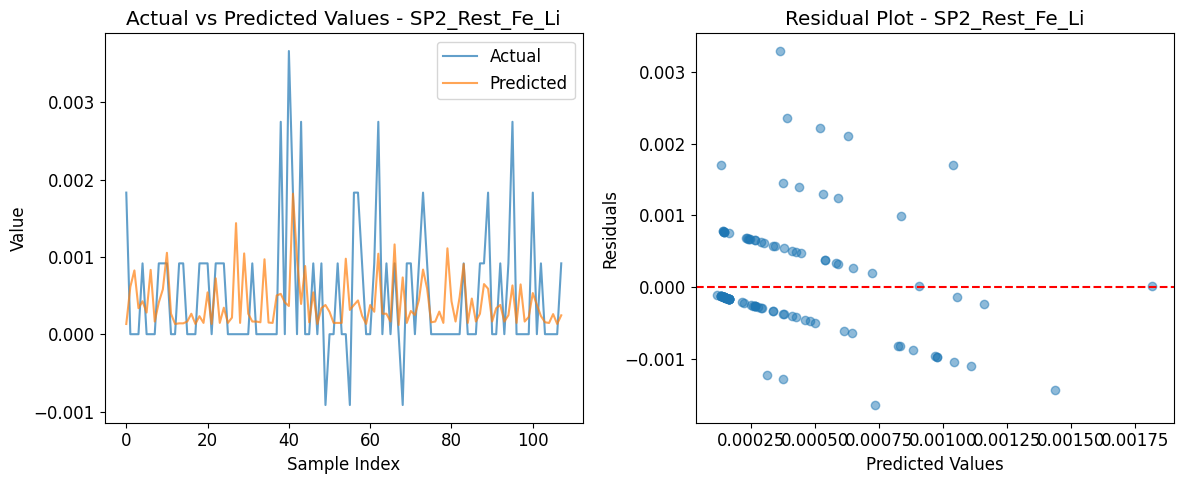


Training model for SP2_Rest_Fe_Mi
[0]	validation_0-rmse:0.00060	validation_1-rmse:0.00070
[1]	validation_0-rmse:0.00059	validation_1-rmse:0.00069
[2]	validation_0-rmse:0.00057	validation_1-rmse:0.00068
[3]	validation_0-rmse:0.00056	validation_1-rmse:0.00067
[4]	validation_0-rmse:0.00055	validation_1-rmse:0.00066
[5]	validation_0-rmse:0.00054	validation_1-rmse:0.00066
[6]	validation_0-rmse:0.00054	validation_1-rmse:0.00065
[7]	validation_0-rmse:0.00053	validation_1-rmse:0.00065
[8]	validation_0-rmse:0.00053	validation_1-rmse:0.00065
[9]	validation_0-rmse:0.00052	validation_1-rmse:0.00064
[10]	validation_0-rmse:0.00051	validation_1-rmse:0.00065
[11]	validation_0-rmse:0.00051	validation_1-rmse:0.00064
[12]	validation_0-rmse:0.00051	validation_1-rmse:0.00064
[13]	validation_0-rmse:0.00050	validation_1-rmse:0.00063
[14]	validation_0-rmse:0.00050	validation_1-rmse:0.00063
[15]	validation_0-rmse:0.00049	validation_1-rmse:0.00063
[16]	validation_0-rmse:0.00049	validation_1-rmse:0.00063
[17]	v

<Figure size 1000x600 with 0 Axes>

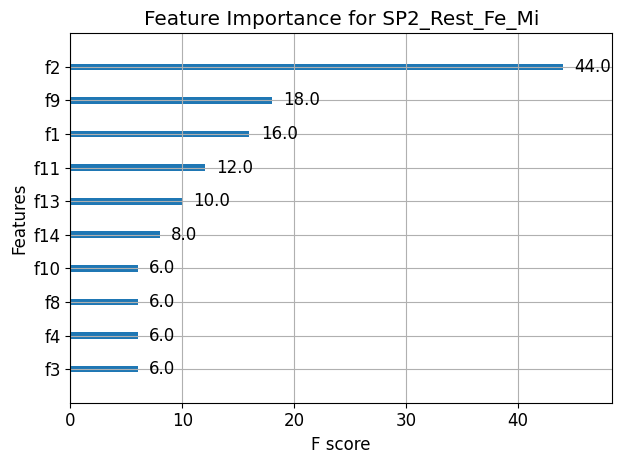

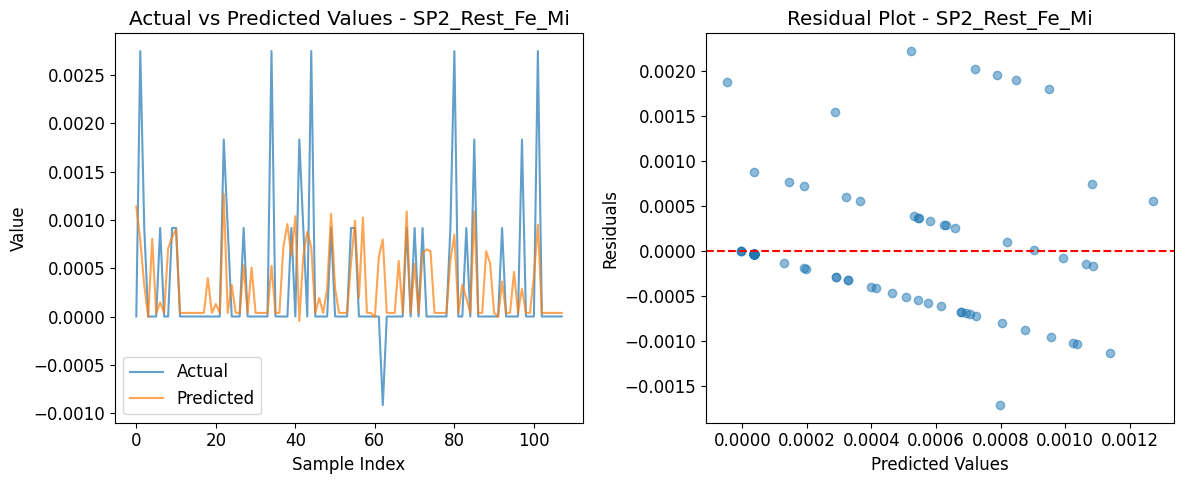


Training model for SP2_Rest_Fe_Re
[0]	validation_0-rmse:0.00066	validation_1-rmse:0.00075
[1]	validation_0-rmse:0.00065	validation_1-rmse:0.00074
[2]	validation_0-rmse:0.00063	validation_1-rmse:0.00073
[3]	validation_0-rmse:0.00062	validation_1-rmse:0.00072
[4]	validation_0-rmse:0.00061	validation_1-rmse:0.00072
[5]	validation_0-rmse:0.00060	validation_1-rmse:0.00072
[6]	validation_0-rmse:0.00060	validation_1-rmse:0.00072
[7]	validation_0-rmse:0.00059	validation_1-rmse:0.00071
[8]	validation_0-rmse:0.00058	validation_1-rmse:0.00071
[9]	validation_0-rmse:0.00058	validation_1-rmse:0.00070
[10]	validation_0-rmse:0.00057	validation_1-rmse:0.00070
[11]	validation_0-rmse:0.00057	validation_1-rmse:0.00070
[12]	validation_0-rmse:0.00056	validation_1-rmse:0.00070
[13]	validation_0-rmse:0.00056	validation_1-rmse:0.00071
[14]	validation_0-rmse:0.00056	validation_1-rmse:0.00071
[15]	validation_0-rmse:0.00055	validation_1-rmse:0.00071
[16]	validation_0-rmse:0.00055	validation_1-rmse:0.00071
[17]	v

<Figure size 1000x600 with 0 Axes>

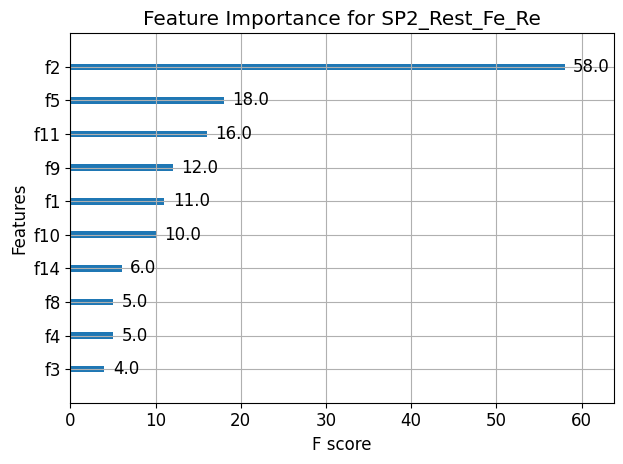

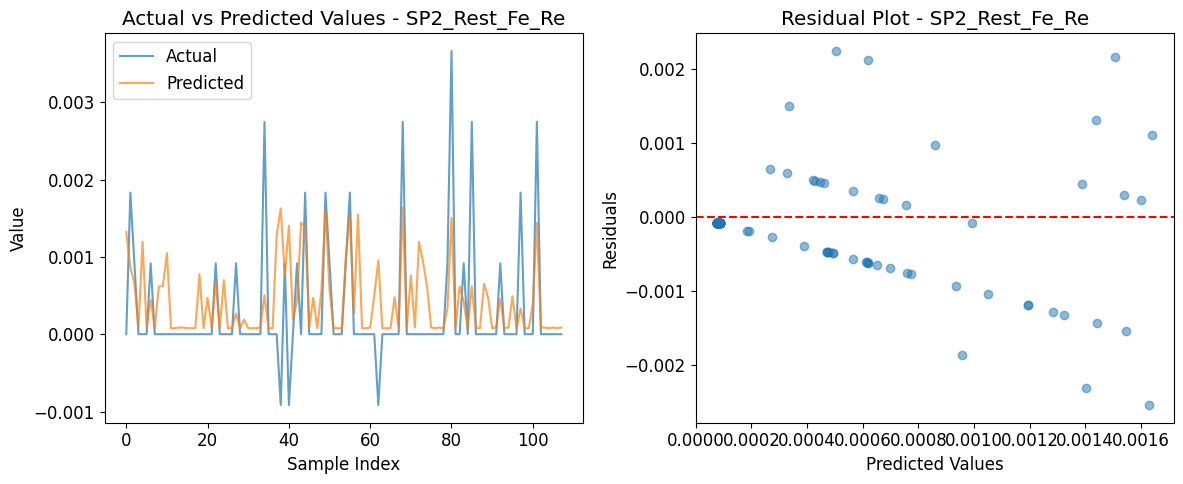


Training completed for all targets!


In [33]:

X = df_artikel[feature_columns].values
y = df_artikel[target_columns].values

# Reshape the data if it's not 2D
if len(X.shape) > 2:
    n_samples = X.shape[0]
    X = X.reshape(n_samples, -1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {}
predictions = {}

for i, target in enumerate(target_columns):
    print(f"\nTraining model for {target}")
    
    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    # Train the model
    model.fit(
        X_train, 
        y_train[:, i],
        eval_set=[(X_train, y_train[:, i]), (X_test, y_test[:, i])],
        verbose=True
    )
    
    # Store the model
    models[target] = model
    
    # Make predictions
    predictions[target] = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test[:, i], predictions[target])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test[:, i], predictions[target])
    r2 = r2_score(y_test[:, i], predictions[target])
    
    print(f"\nMetrics for {target}:")
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R2 Score: {r2:.4f}')
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    xgb.plot_importance(model, max_num_features=10)
    plt.title(f'Feature Importance for {target}')
    plt.tight_layout()
    plt.show()
    
    # Plot actual vs predicted
    plt.figure(figsize=(12, 5))
    
    # Actual vs Predicted plot
    plt.subplot(1, 2, 1)
    plt.plot(y_test[:, i], label='Actual', alpha=0.7)
    plt.plot(predictions[target], label='Predicted', alpha=0.7)
    plt.title(f'Actual vs Predicted Values - {target}')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    
    # Residuals plot
    plt.subplot(1, 2, 2)
    residuals = y_test[:, i] - predictions[target]
    plt.scatter(predictions[target], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot - {target}')
    
    plt.tight_layout()
    plt.show()

# Save models if needed
for target, model in models.items():
    model.save_model(f'xgb_model_{target}.json')

print("\nTraining completed for all targets!")

simpler algorithms like xgboost does not really do a good job either.

To get more data, we can maybe group some of the products. If it is not enough, we could put all products together.

First, let's group them. From the article name, looks like we have 3 parts: a code, another code and a number.

The last number seems to be the width of the article. 

First code seems like an ID and the second code seems like quality. 

Some strategies could be:

- take all products starting from a Letter, like family
- take all products of the same quality

in both cases, I should not use the width variables since they are dependent to the product.

In [12]:
df_artikel = df[df["artikel"].str.startswith("B")]
df_artikel = df_artikel[["capture_ts","object_id","value_decimal"]]
df_artikel = df_artikel.pivot_table(index="capture_ts",columns="object_id",values="value_decimal")
df_artikel = df_artikel.reset_index()
nan_counts = df_artikel.isna().sum()
print("\nCount of NaN values in each column:")
print(nan_counts)

print (df_artikel.shape)
print (df_artikel)



Count of NaN values in each column:
object_id
capture_ts                0
SP2_Breite01              4
SP2_Breite02              4
SP2_Breite03              4
SP2_Breite04              4
SP2_Breite05              4
SP2_Breite06              4
SP2_Breite07              4
SP2_Breite08              4
SP2_Breite09              4
SP2_Breite10              4
SP2_Breite11              4
SP2_Diff_EA_Ge            0
SP2_Diff_EA_Me            0
SP2_Duese_vW_Fixomat01    4
SP2_Duese_vW_Fixomat02    4
SP2_Duese_vW_Fixomat03    4
SP2_Duese_vW_Fixomat04    4
SP2_Duese_vW_Fixomat05    4
SP2_Duese_vW_Fixomat06    4
SP2_Duese_vW_Fixomat07    4
SP2_Duese_vW_Fixomat08    4
SP2_Duese_vW_Fixomat09    4
SP2_Geschw_Ausl           0
SP2_Geschw_Einl           0
SP2_Meterz_Ausl           0
SP2_Meterz_Einl           0
SP2_Rest_Fe_Li            0
SP2_Rest_Fe_Mi            0
SP2_Rest_Fe_Re            0
SP2_Sieb_nW_Fixomat01     4
SP2_Sieb_nW_Fixomat02     4
SP2_Sieb_nW_Fixomat03     4
SP2_Sieb_nW_Fixomat04     4
S

In [13]:
df_artikel = df_artikel.dropna()

# remove also values when the machine is stopped.
print (len(df_artikel))
list_time_stopped = df_artikel.query("SP2_Geschw_Ausl == 0").capture_ts
print (list_time_stopped)
df_artikel = df_artikel[~df_artikel['capture_ts'].isin(list_time_stopped)]
print (len(df_artikel))
df_artikel = df_artikel.reset_index(drop=True)


168661
625      2022-09-01 11:39:14
626      2022-09-01 11:39:24
627      2022-09-01 11:39:34
628      2022-09-01 11:39:44
629      2022-09-01 11:39:54
                 ...        
168641   2024-04-05 22:34:41
168642   2024-04-05 22:34:51
168643   2024-04-05 22:35:01
168644   2024-04-05 22:35:11
168645   2024-04-05 22:35:21
Name: capture_ts, Length: 12413, dtype: datetime64[ns]
156248


In [14]:
import re

r = re.compile(".*Breite.*")
remove_list = list(filter(r.match, df_artikel.columns.values.tolist())) 
print(remove_list)
df_artikel = df_artikel.drop(remove_list,axis=1)


['SP2_Breite01', 'SP2_Breite02', 'SP2_Breite03', 'SP2_Breite04', 'SP2_Breite05', 'SP2_Breite06', 'SP2_Breite07', 'SP2_Breite08', 'SP2_Breite09', 'SP2_Breite10', 'SP2_Breite11']


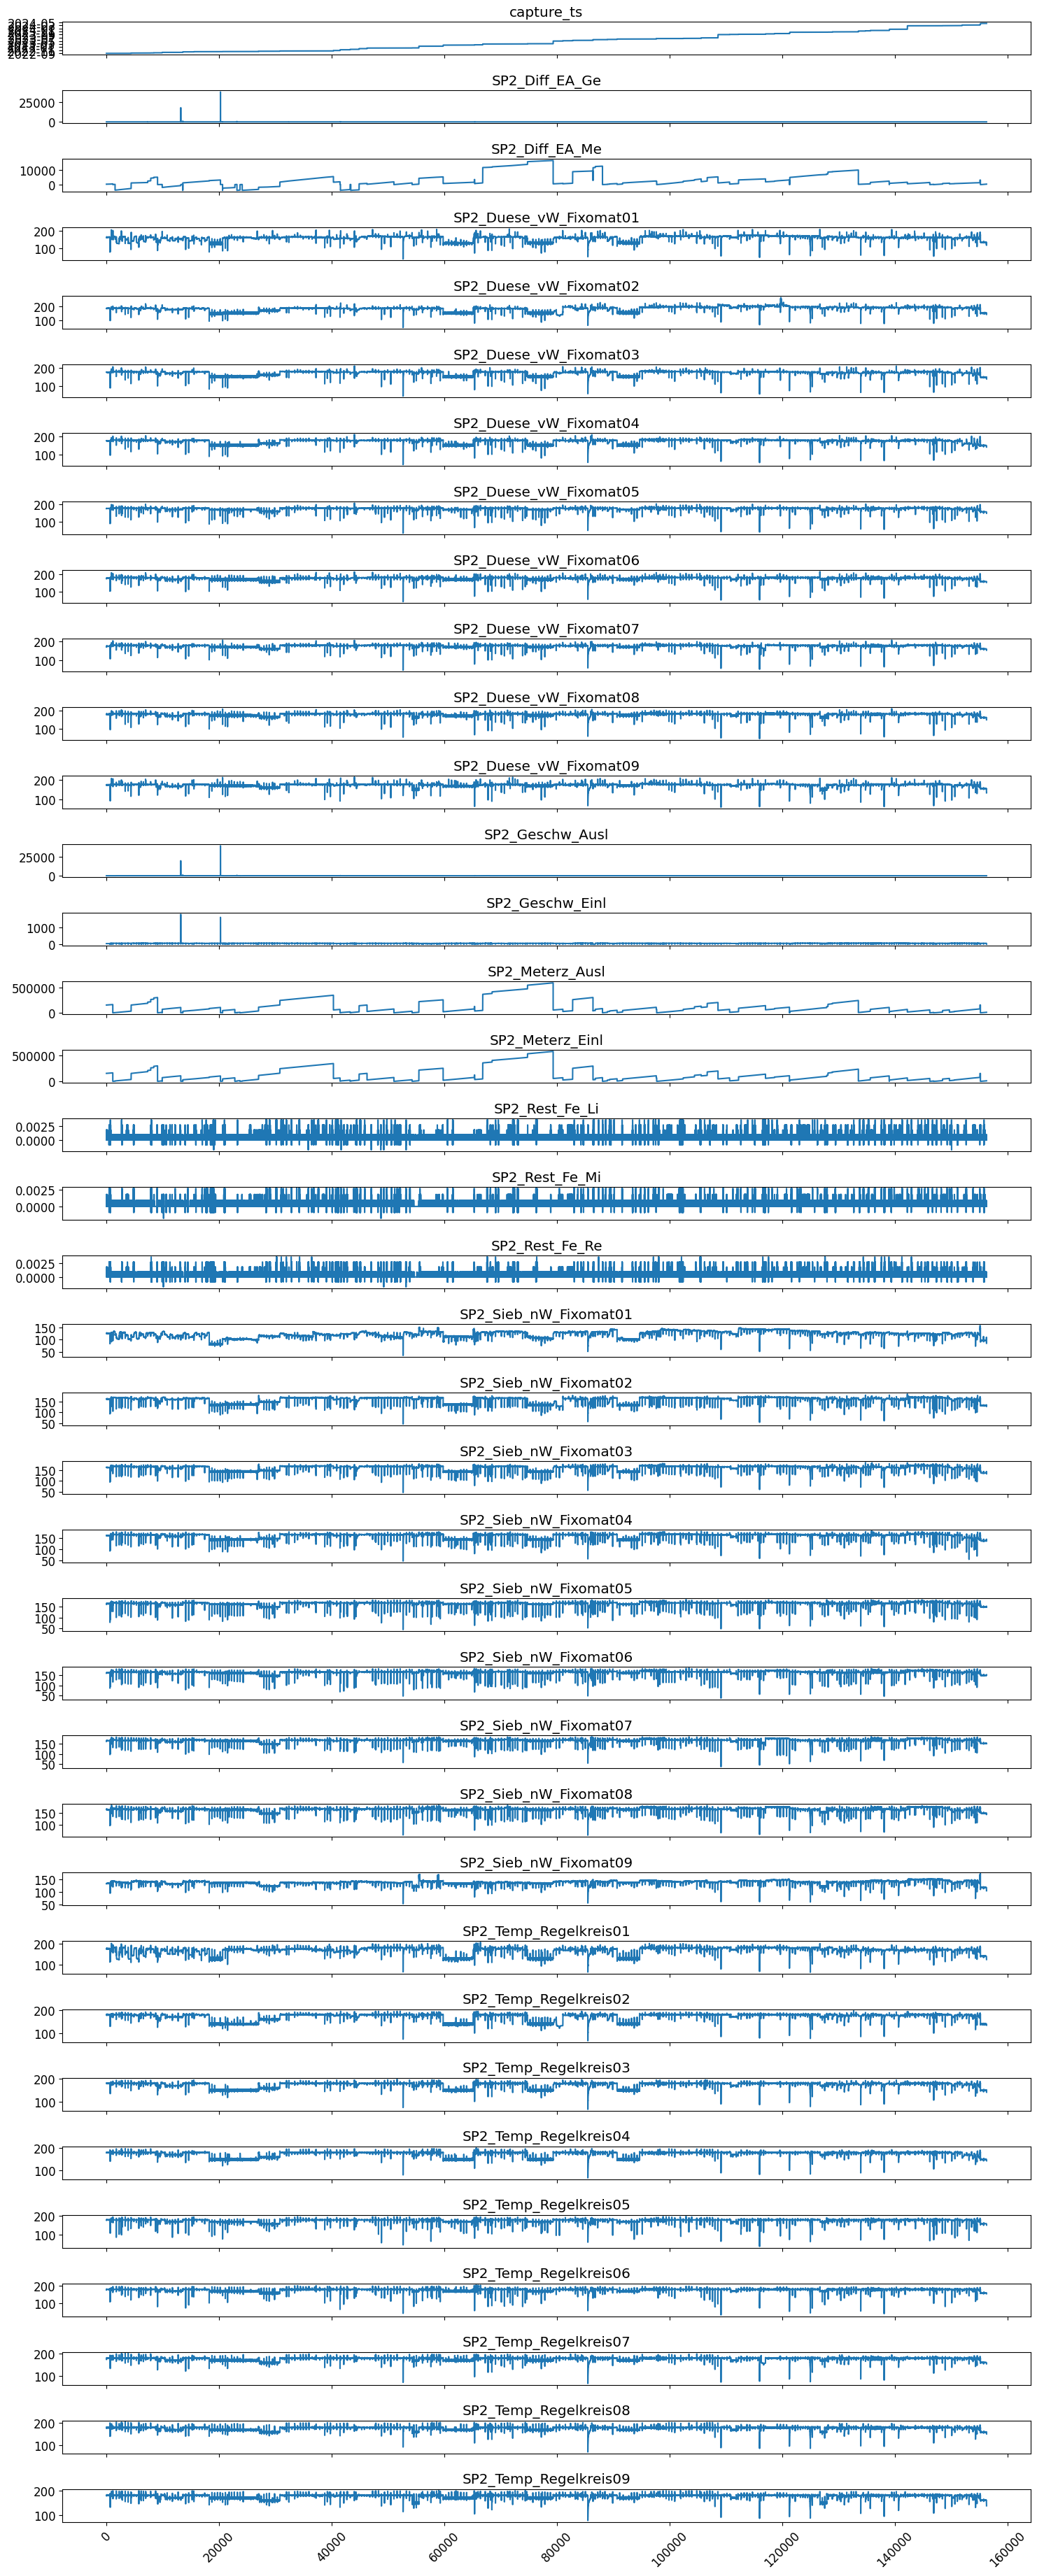

In [67]:
n_plots = df_artikel.shape[1]
fig, axes = plt.subplots(n_plots, 1, figsize=(15, 1*n_plots), sharex=True)

#df_aux = df_cleaned.copy().iloc[1000:2000]
df_aux = df_artikel.copy()

for i, col in enumerate(df_artikel.columns):
    axes[i].plot(df_aux[col])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [105]:
print (set(df_artikel["SP2_Rest_Fe_Li"]))
print (set(df_artikel["SP2_Rest_Fe_Re"]))
print (set(df_artikel["SP2_Rest_Fe_Mi"]))
print (df_artikel.shape)

{0.0, 0.0009159999899566174, 0.0027469999622553587, 0.0018309999722987413, -0.0009159999899566174, 0.0036619999445974827, -0.0018309999722987413}
{0.0009159999899566174, 0.0, -0.0009159999899566174, 0.0018309999722987413, 0.0027469999622553587, 0.0036619999445974827, -0.0018309999722987413}
{0.0, 0.0009159999899566174, 0.0027469999622553587, 0.0018309999722987413, -0.0009159999899566174, -0.0018309999722987413}
(156240, 37)


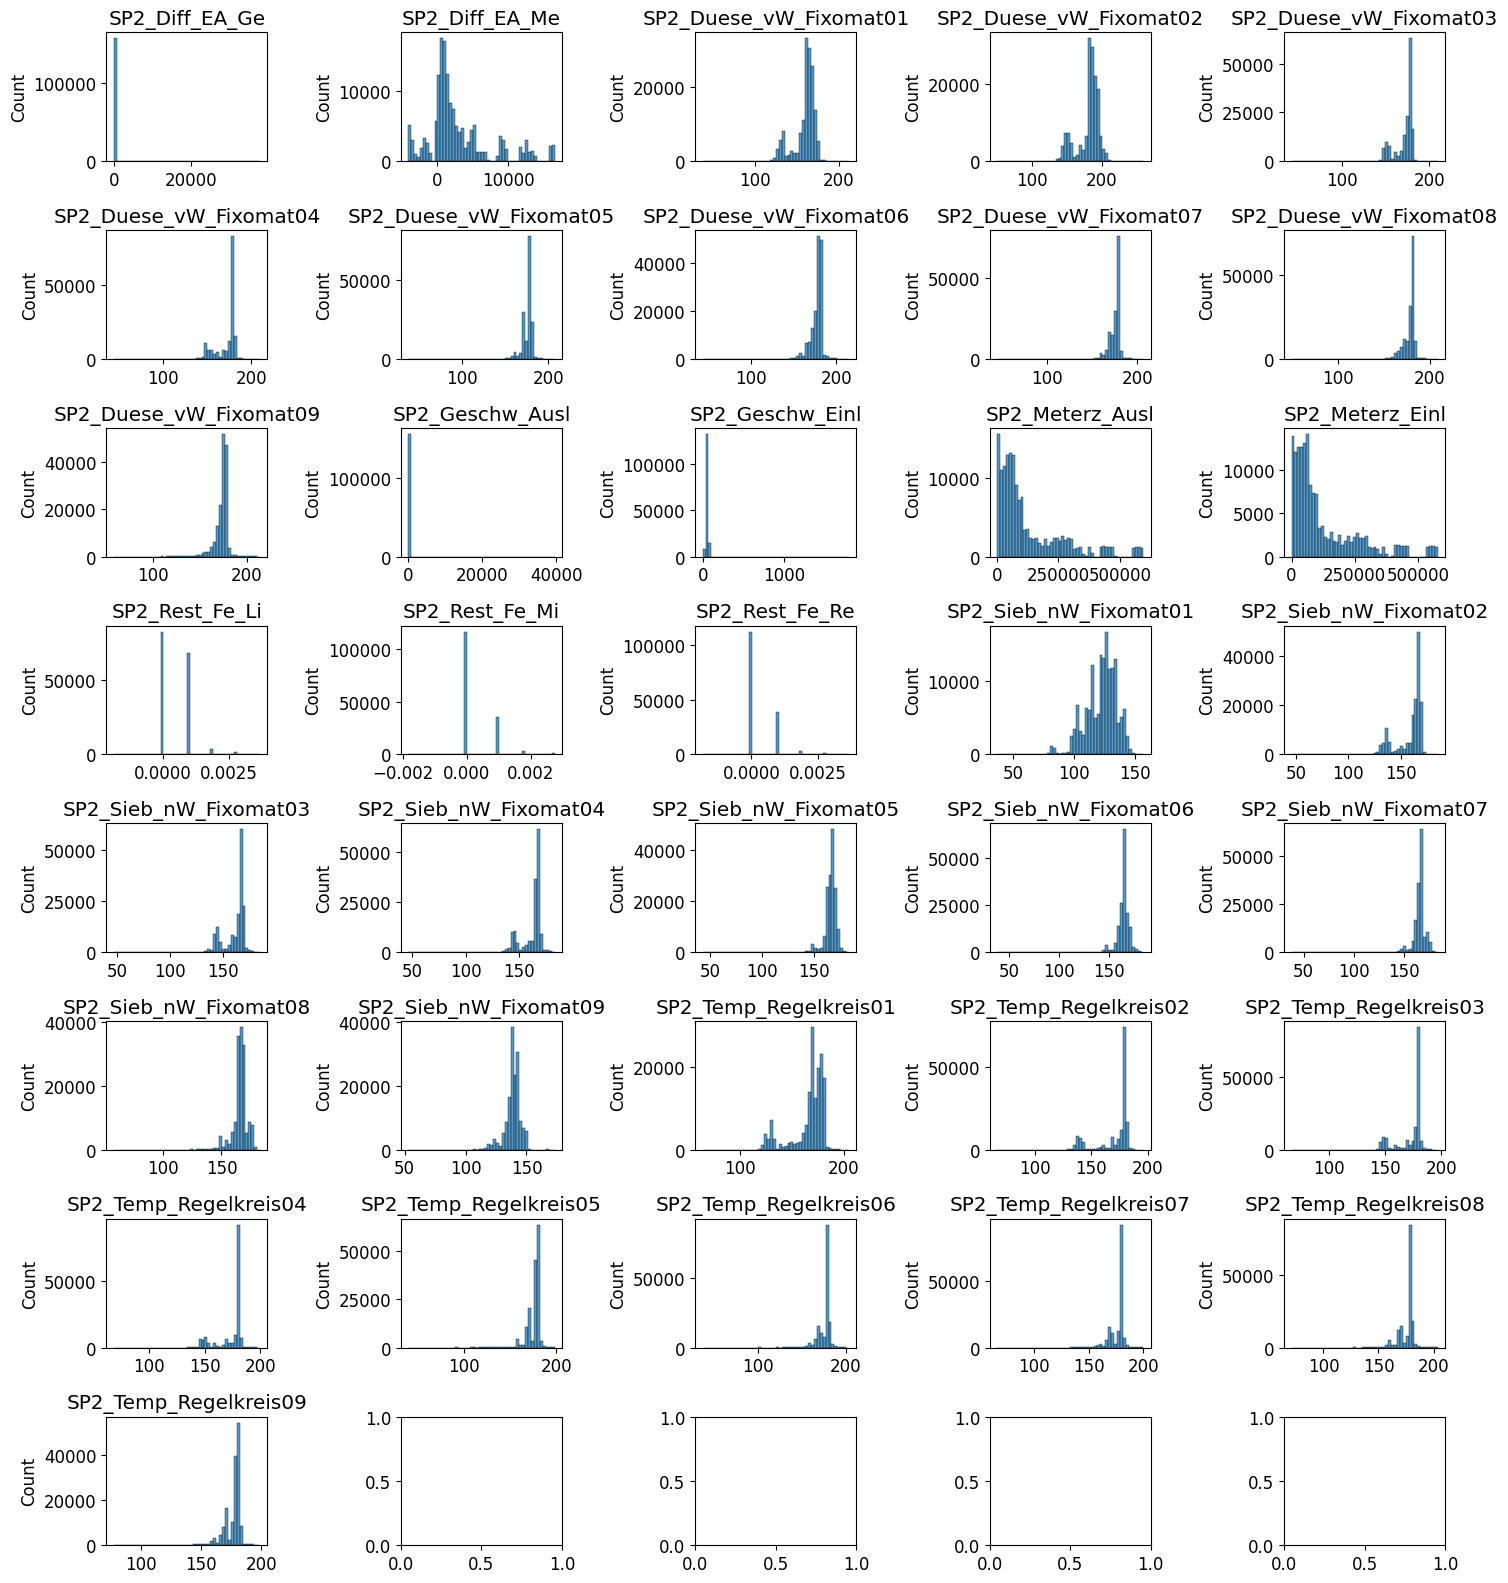

In [68]:
n_cols = 5

float_cols = df_artikel.columns[1:]

n_rows = math.ceil(len(float_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 2*n_rows))
axes = axes.flatten()
plt.rcParams.update({'font.size': 12})

for i, col in enumerate(df_artikel[float_cols]):
    sns.histplot(df_artikel[col], bins=50, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
plt.tight_layout()
plt.show()

156248
156240


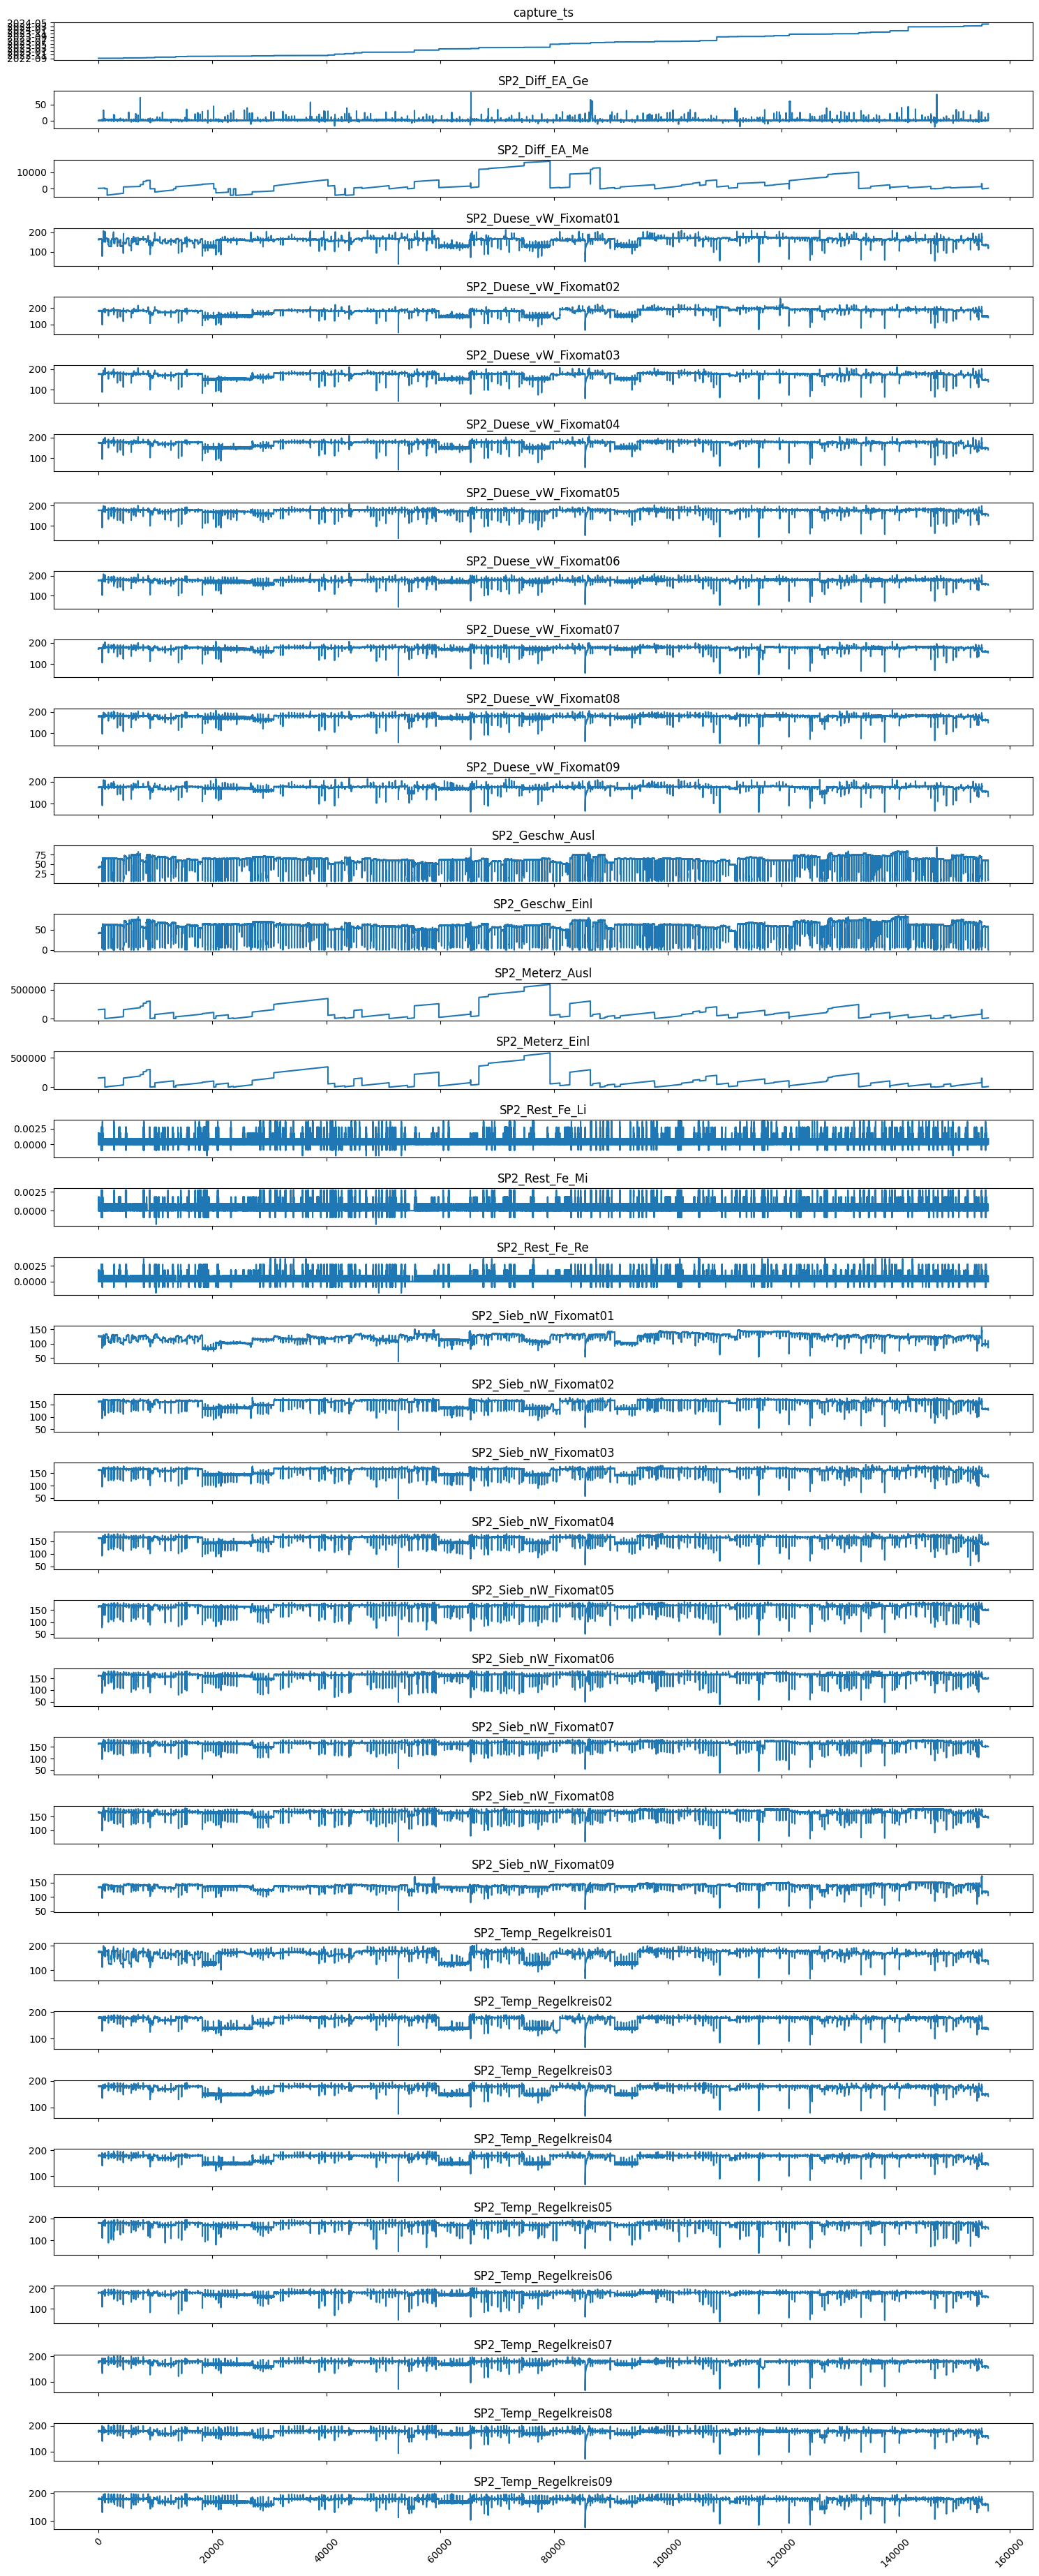

In [15]:
# remove outliers from SP2_Diff_EA_Me, SP2_Geschw_Ausl, SP2_Geschw_Einl
print (len(df_artikel))
df_artikel = df_artikel[df_artikel["SP2_Diff_EA_Ge"] < 125]
df_artikel = df_artikel[df_artikel["SP2_Geschw_Ausl"] < 125]
df_artikel = df_artikel[df_artikel["SP2_Geschw_Einl"] < 5000]
print (len(df_artikel))

n_plots = df_artikel.shape[1]
fig, axes = plt.subplots(n_plots, 1, figsize=(15, 1*n_plots), sharex=True)

#df_aux = df_cleaned.copy().iloc[1000:2000]
df_aux = df_artikel.copy()

for i, col in enumerate(df_artikel.columns):
    axes[i].plot(df_aux[col])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

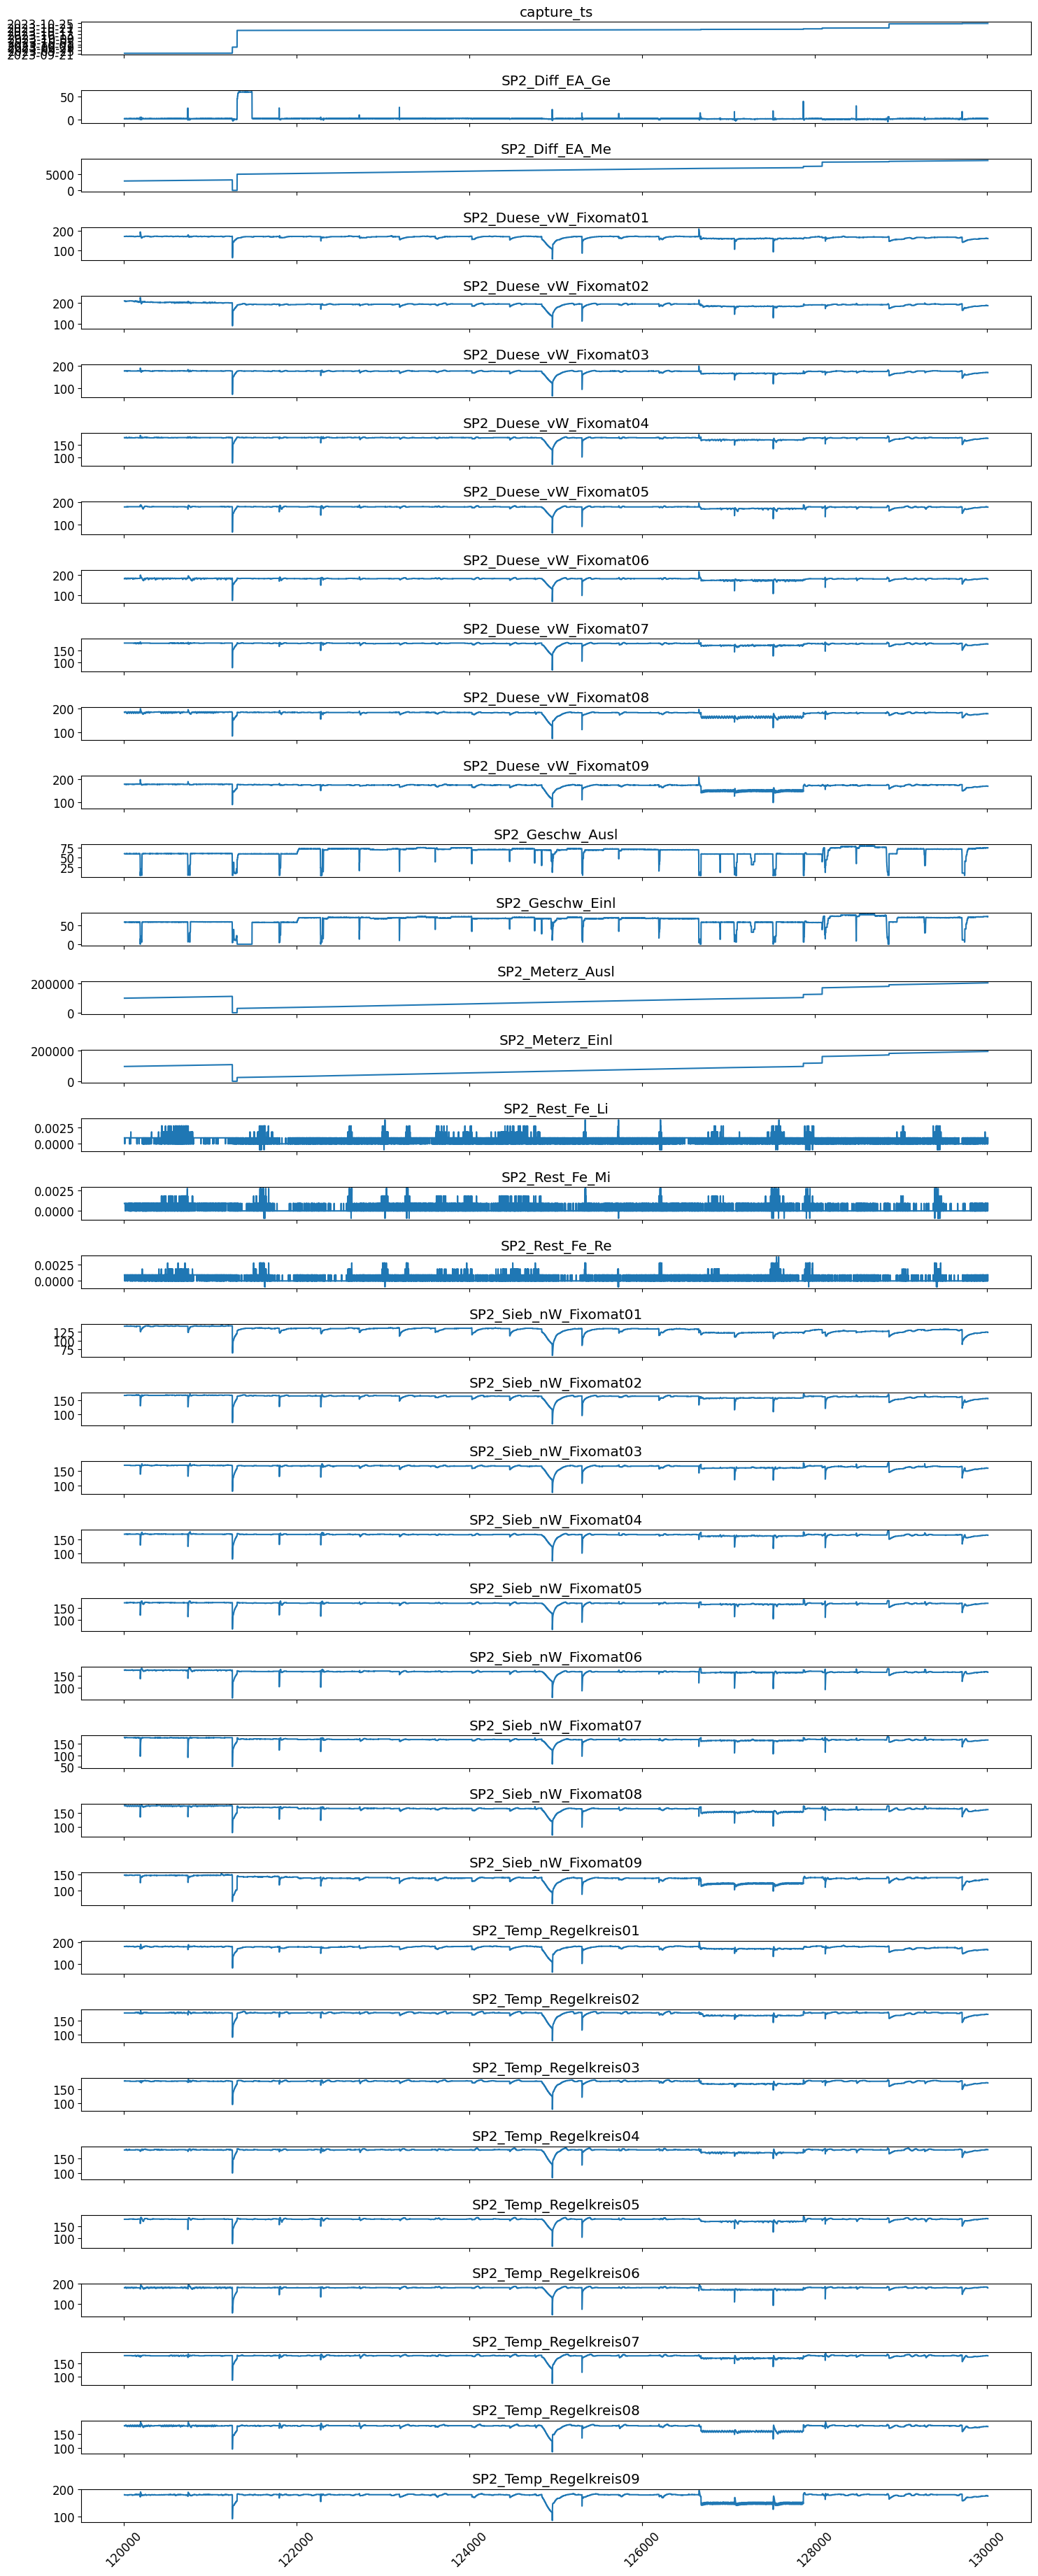

In [101]:
n_plots = df_artikel.shape[1]
fig, axes = plt.subplots(n_plots, 1, figsize=(15, 1*n_plots), sharex=True)

df_aux = df_artikel.copy()
df_aux = df_aux[120000:130000]

for i, col in enumerate(df_artikel.columns):
    axes[i].plot(df_aux[col])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

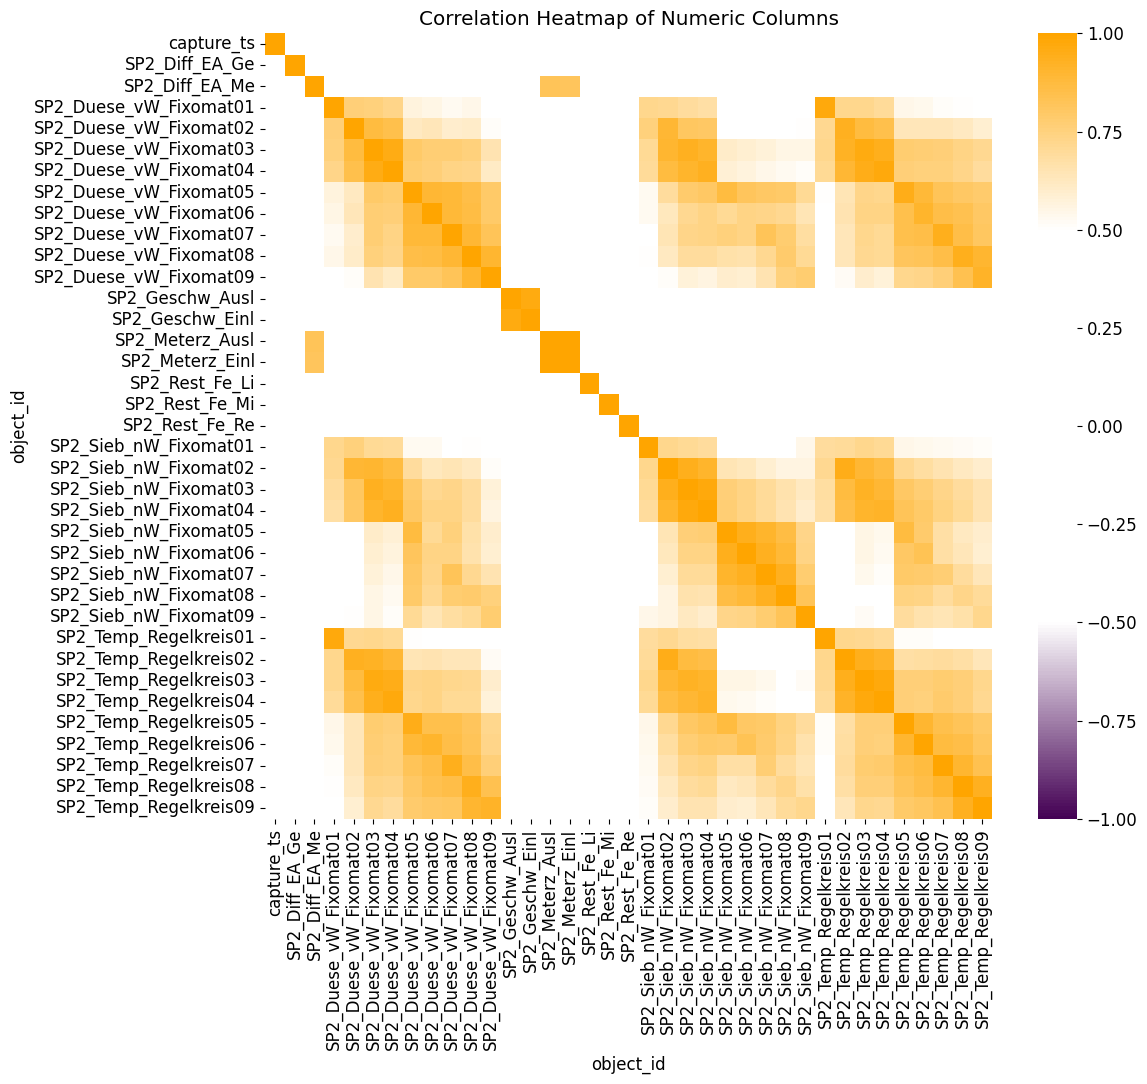

In [73]:

corr_matrix = df_artikel.corr()

blue_r = LinearSegmentedColormap.from_list("", ["#440154", "white"])
red = LinearSegmentedColormap.from_list("", ["white", "orange"])

colors = np.vstack((blue_r(np.linspace(0, 1, 128)),
                    np.array([[1,1,1,1]]*255),  # White for the middle range
                    red(np.linspace(0, 1, 128))))
custom_cmap = ListedColormap(colors)

colors = ['#3B4CC0', '#FFFFFF', '#B40426']  # Blue, White, Red
n_bins = 100
cmap = LinearSegmentedColormap.from_list("custom_diverging", colors, N=n_bins)
    
# Create a heatmap
plt.figure(figsize=(12, 11))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap=custom_cmap, vmin=-1, vmax=1, center=0,annot_kws={"size": 8})
plt.title('Correlation Heatmap of Numeric Columns')
plt.tight_layout()
plt.show()

In [93]:
target_columns = ['SP2_Rest_Fe_Li', 'SP2_Rest_Fe_Mi', 'SP2_Rest_Fe_Re']
final_cols = df_artikel.columns
feature_columns = [f for f in final_cols if f not in target_columns]
feature_columns.remove("capture_ts")

cutoff = 0.02
variables = []
for target in ["SP2_Rest_Fe_Li","SP2_Rest_Fe_Mi","SP2_Rest_Fe_Re"]:
    v = df_artikel[feature_columns].apply(mutual_info_score,target=target)
    print (v)
    vs = v[v > cutoff].index
    variables.extend(vs)

final_cols = list(set((variables)))
print (final_cols)

object_id
SP2_Diff_EA_Ge            0.035669
SP2_Diff_EA_Me            0.063691
SP2_Duese_vW_Fixomat01    0.019299
SP2_Duese_vW_Fixomat02    0.027130
SP2_Duese_vW_Fixomat03    0.011552
SP2_Duese_vW_Fixomat04    0.011639
SP2_Duese_vW_Fixomat05    0.013413
SP2_Duese_vW_Fixomat06    0.008812
SP2_Duese_vW_Fixomat07    0.011990
SP2_Duese_vW_Fixomat08    0.011013
SP2_Duese_vW_Fixomat09    0.011382
SP2_Geschw_Ausl           0.023747
SP2_Geschw_Einl           0.019451
SP2_Meterz_Ausl           0.051553
SP2_Meterz_Einl           0.051282
SP2_Sieb_nW_Fixomat01     0.024872
SP2_Sieb_nW_Fixomat02     0.017348
SP2_Sieb_nW_Fixomat03     0.014590
SP2_Sieb_nW_Fixomat04     0.012341
SP2_Sieb_nW_Fixomat05     0.013791
SP2_Sieb_nW_Fixomat06     0.016517
SP2_Sieb_nW_Fixomat07     0.014973
SP2_Sieb_nW_Fixomat08     0.011239
SP2_Sieb_nW_Fixomat09     0.015047
SP2_Temp_Regelkreis01     0.010102
SP2_Temp_Regelkreis02     0.015222
SP2_Temp_Regelkreis03     0.012115
SP2_Temp_Regelkreis04     0.012465
SP2_Temp_R

Let's try again training the model

In [94]:
target_columns = ['SP2_Rest_Fe_Li', 'SP2_Rest_Fe_Mi', 'SP2_Rest_Fe_Re']
feature_columns = [f for f in final_cols if f not in target_columns]
all_features = feature_columns+target_columns

df_aux = df_artikel[all_features]
target_indices = [df_aux.columns.get_loc(col) for col in target_columns]
print (target_indices)

data = df_aux.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences to give temporal context to the model
def create_sequences(data, seq_length, target_indices):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, target_indices]) 
    return np.array(X), np.array(y)

seq_length = 5  # window size

X, y = create_sequences(scaled_data, seq_length, target_indices)

print(X.shape, y.shape)

# 80, 20, 20 @ train, validation, test.
# data is sequential, so no shuffling.

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=False)

print(X_train.shape, X_val.shape, X_test.shape)
print(len(df_aux))

[7, 8, 9]
(156235, 5, 10) (156235, 3)
(93741, 5, 10) (31247, 5, 10) (31247, 5, 10)
156240


In [98]:
inputs = keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = layers.LSTM(16, recurrent_dropout=0.1,activation="relu")(inputs)
x = layers.BatchNormalization()(x)   # added new
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(target_columns))(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='textiles_lstm_test.keras',
                                   monitor='val_loss',
                                   save_best_only=True)
    ]

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.summary()
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, validation_data=(X_val, y_val), callbacks=callbacks) #doubled batch size



Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 16)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,843 (7.20 KB)

 Trainable params: 1,811 (7.07 KB)

 Non-trainable params: 32 (128.00 B)

Epoch 1/50


1465/1465 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0832 - mae: 0.1747 - val_loss: 0.0108 - val_mae: 0.0825
Epoch 2/50
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0091 - mae: 0.0711 - val_loss: 0.0105 - val_mae: 0.0810
Epoch 3/50
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0080 - mae: 0.0664 - val_loss: 0.0100 - val_mae: 0.0841
Epoch 4/50
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0079 - mae: 0.0659 - val_loss: 0.0104 - val_mae: 0.0802
Epoch 5/50
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0079 - mae: 0.0660 - val_loss: 0.0099 - val_mae: 0.0810
Epoch 6/50
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0079 - mae: 0.0659 - val_loss: 0.0101 - val_mae: 0.0796
Epoch 7/50
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0078 - mae: 0.0658 - val_loss: 0.0099 - val_mae: 0.0805
Epoch 8/50
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0079 - mae: 0.0661 - val_loss: 0.0099 - val_mae: 0.0805
Epoch 9/50
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

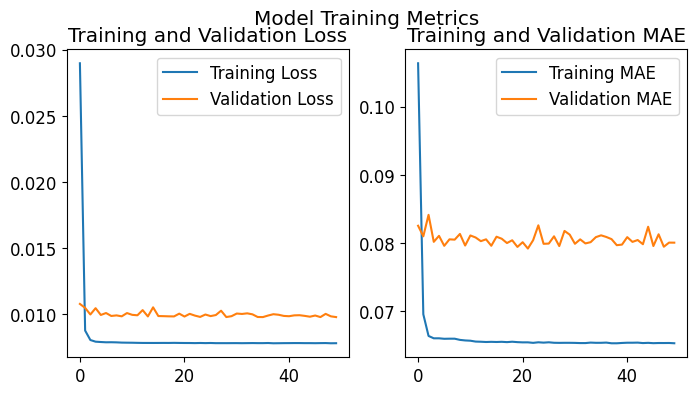

Best val loss: 0.00976579263806343


In [99]:
validation_metrics_plot(history, "Model Training Metrics")

977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step

Metrics for SP2_Rest_Fe_Li:
MSE: 0.0000
RMSE: 0.0005
MAE: 0.0004
R2 Score: 0.1093
MAPE: inf%

Metrics for SP2_Rest_Fe_Mi:
MSE: 0.0000
RMSE: 0.0004
MAE: 0.0003
R2 Score: 0.1465
MAPE: inf%

Metrics for SP2_Rest_Fe_Re:
MSE: 0.0000
RMSE: 0.0005
MAE: 0.0004
R2 Score: 0.1345
MAPE: inf%


/tmp/ipykernel_60049/3626170324.py:34: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100
/tmp/ipykernel_60049/3626170324.py:34: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100
/tmp/ipykernel_60049/3626170324.py:34: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100


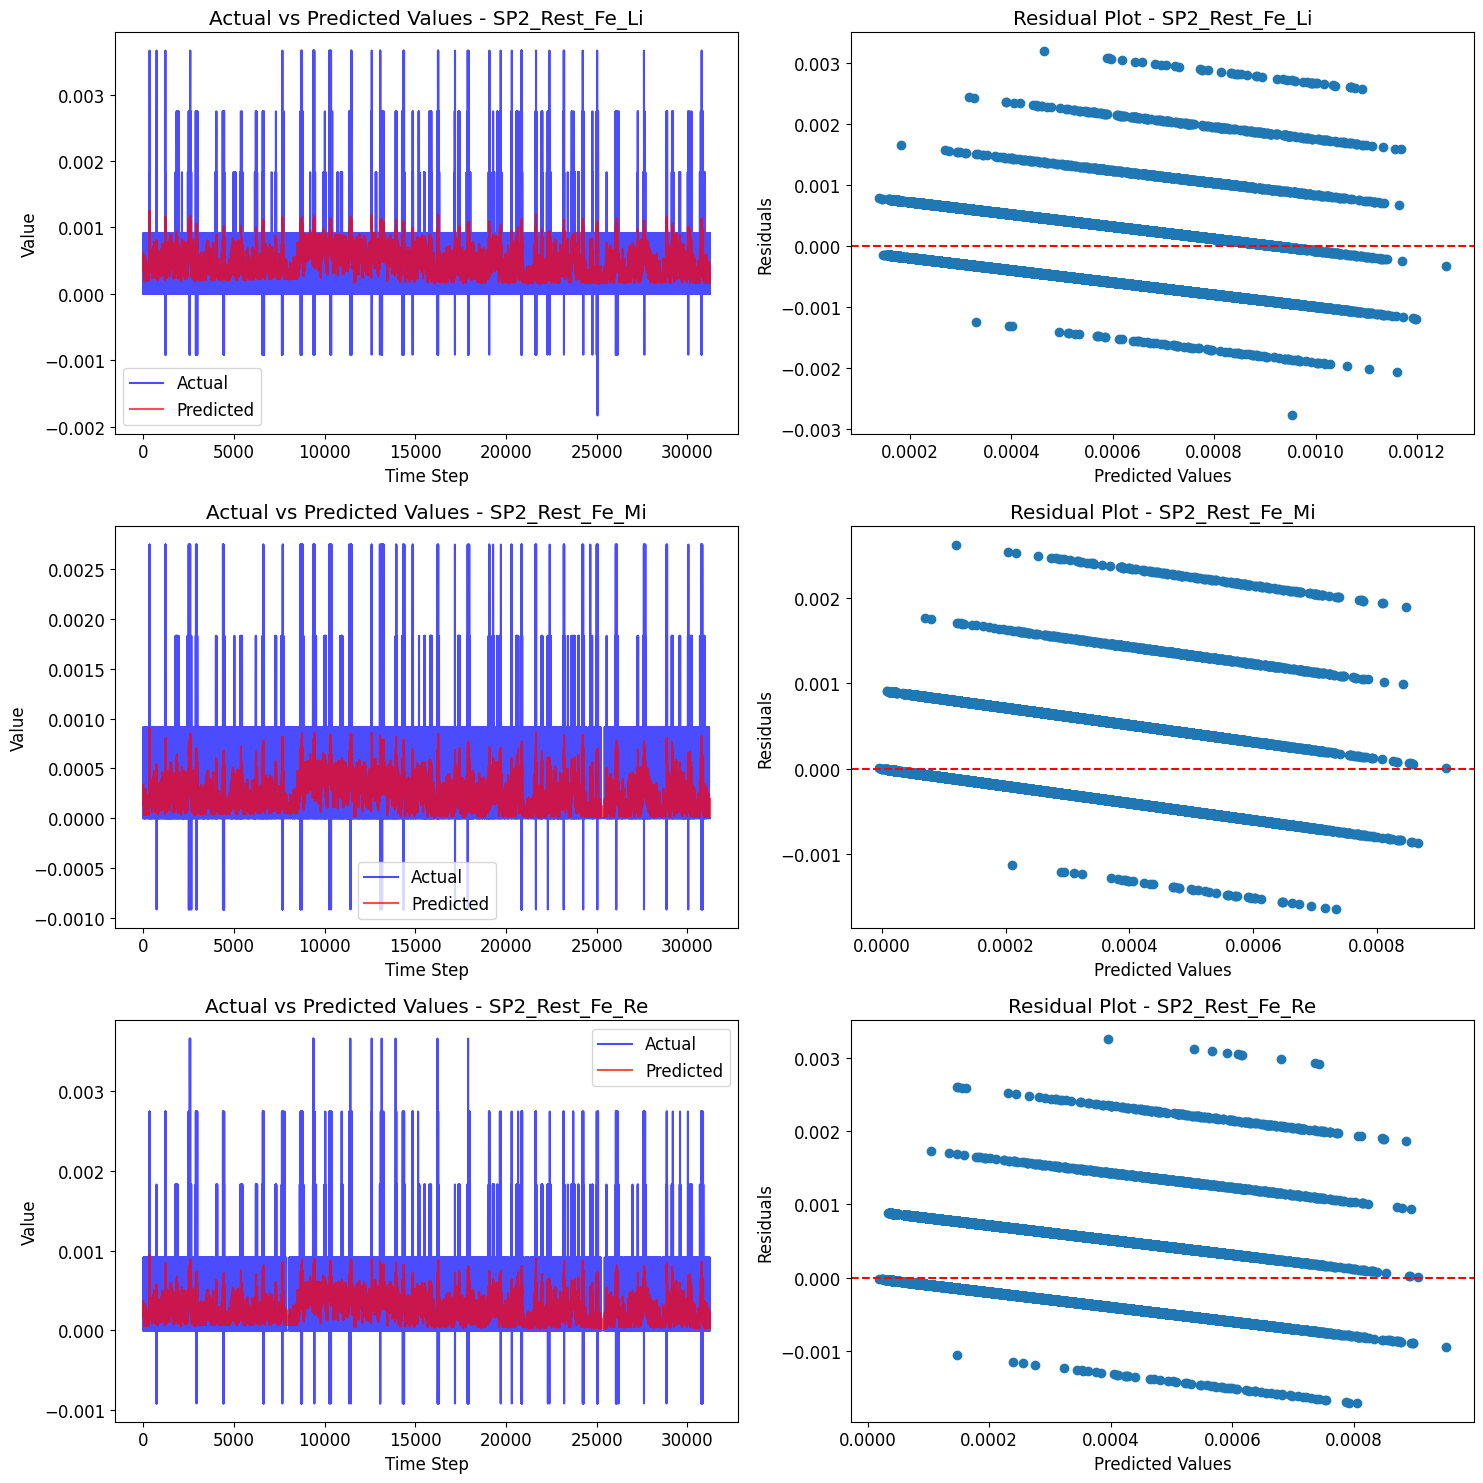

In [100]:
results = evaluate_and_predict(model, X_test, y_test, 
                              target_columns=target_columns, 
                              scaler=scaler, 
                              features=all_features)

Try to classify instead of doing a regression

In [21]:
for i in set(df_artikel["SP2_Rest_Fe_Li"]):
    print (f"{i}: {df_artikel["SP2_Rest_Fe_Li"].tolist().count(i)}")

0.0: 82361
0.0009159999899566174: 68132
0.0027469999622553587: 1499
0.0018309999722987413: 3504
-0.0009159999899566174: 476
0.0036619999445974827: 259
-0.0018309999722987413: 9


Distribution of the values is very heterogeneous and we have very few values for 3 of them in this case.

['SP2_Geschw_Ausl', 'SP2_Diff_EA_Ge', 'SP2_Diff_EA_Me', 'SP2_Duese_vW_Fixomat02', 'SP2_Sieb_nW_Fixomat01', 'SP2_Meterz_Einl', 'SP2_Meterz_Ausl', 'SP2_Rest_Fe_Li', 'SP2_Rest_Fe_Mi', 'SP2_Rest_Fe_Re']
[7, 8, 9]
Number of classes: 7
Classes: [0.         0.16657563 0.3333333  0.500091   0.6666666  0.8334243
 0.99999994]
Class distribution: Counter({np.int64(2): 112534, np.int64(3): 39200, np.int64(4): 2929, np.int64(5): 1088, np.int64(1): 444, np.int64(6): 36, np.int64(0): 4})


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 16)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,911 (7.46 KB)

 Trainable params: 1,879 (7.34 KB)

 Non-trainable params: 32 (128.00 B)

Epoch 1/100
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6736 - loss: 0.8729 - val_accuracy: 0.7394 - val_loss: 0.6002 - learning_rate: 0.0010
Epoch 2/100
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7298 - loss: 0.6158 - val_accuracy: 0.7388 - val_loss: 0.6004 - learning_rate: 0.0010
Epoch 3/100
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7292 - loss: 0.6120 - val_accuracy: 0.7405 - val_loss: 0.5956 - learning_rate: 0.0010
Epoch 4/100
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7332 - loss: 0.6064 - val_accuracy: 0.7409 - val_loss: 0.5864 - learning_rate: 0.0010
Epoch 5/100
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7328 - loss: 0.6048 - val_accuracy: 0.7384 - val_loss: 0.5890 - learning_rate: 0.0010
Epoch 6/100
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7355 - loss: 0.5993 - val_accuracy: 0.7402 - val_loss: 0.5902 - learning_rate: 0.0010
Epoch 7/100
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7

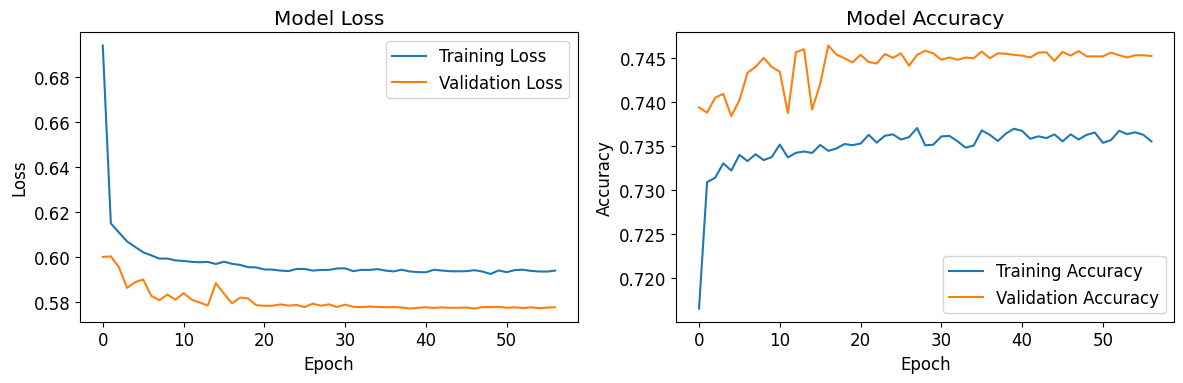

733/733 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step - accuracy: 0.7337 - loss: 0.5873

Test accuracy: 0.7381
733/733 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step

Confusion Matrix:
[[    0     0     1     0     0     0     0]
 [    0     0    75     0     0     0     0]
 [    0     0 15816   957     1     0     0]
 [    0     0  4531  1482     0     0     0]
 [    0     0   380    31     0     0     0]
 [    0     0   149     9     0     0     0]
 [    0     0     3     1     0     0     0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        75
           2       0.75      0.94      0.84     16774
           3       0.60      0.25      0.35      6013
           4       0.00      0.00      0.00       411
           5       0.00      0.00      0.00       158
           6       0.00      0.00      0.00         4

    accuracy                           0.74     23436
   macro a

/home/ibai/.local/share/virtualenvs/textile-RlY57q6n/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibai/.local/share/virtualenvs/textile-RlY57q6n/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibai/.local/share/virtualenvs/textile-RlY57q6n/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [122]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from collections import Counter

target_columns = ['SP2_Rest_Fe_Li', 'SP2_Rest_Fe_Mi', 'SP2_Rest_Fe_Re']
feature_columns = [f for f in final_cols if f not in target_columns]
all_features = feature_columns+target_columns

print (all_features)

df_aux = df_artikel[all_features]
target_indices = [df_aux.columns.get_loc(col) for col in target_columns]
print (target_indices)

data = df_aux.values

# 1. Prepare the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 2. Get target index for SP3_Rest_Fe_Re
target_column = 'SP2_Rest_Fe_Re'
target_idx = df_aux.columns.get_loc(target_column)

# 3. Create sequences
seq_length = 5  # window size
X, y = create_sequences(scaled_data, seq_length, [target_idx])

# 4. Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.flatten())  # flatten because y is 2D
y_categorical = to_categorical(y_encoded)

print("Number of classes:", len(label_encoder.classes_))
print("Classes:", label_encoder.classes_)
print("Class distribution:", Counter(y_encoded))

# 5. Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y_categorical, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 6. Create the classification model
inputs = keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = layers.LSTM(16, recurrent_dropout=0.1, activation="relu")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(label_encoder.classes_), activation='softmax')(x)  # softmax for classification
model = keras.Model(inputs=inputs, outputs=outputs)

# 7. Compile with classification loss
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='textiles_lstm_classification.keras',
        monitor='val_loss',
        save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001
    )
]

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy',  # Changed to categorical_crossentropy
    metrics=['accuracy']  # Added accuracy metric
)

model.summary()

# 8. Train the model
history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

# 9. Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 10. Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")

# 11. Make predictions and show confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes))

In [7]:

# Code for TASK 2

df_list = []

parquet_files = [f for f in os.listdir("data") if f.endswith('.parquet')]
parquet_files = sorted(parquet_files)

subset = parquet_files[-5:] # get most recent, not enough memory
print (subset)

for p in subset:
    df = pd.read_parquet(f"data/{p}")
    print (f"data/{p} loaded")
    df_list.append(df)

df = pd.concat(df_list)
        

['2023-12.parquet', '2024-01.parquet', '2024-02.parquet', '2024-03.parquet', '2024-04.parquet']
data/2023-12.parquet loaded
data/2024-01.parquet loaded
data/2024-02.parquet loaded
data/2024-03.parquet loaded
data/2024-04.parquet loaded


1211

In [25]:

df = pd.read_parquet("data/2024-04.parquet")

In [26]:
df

capture_ts              object_id  value_decimal  \
32640   2024-04-03 10:59:39                StromL1     187.167496   
32641   2024-04-03 10:59:39            Wirkenergie  647809.937500   
32642   2024-04-03 10:59:39     Wirkleistung Strom   86655.671875   
32646   2024-04-03 10:59:39                StromL2     184.245605   
32647   2024-04-03 10:59:39                StromL3     187.633301   
...                     ...                    ...            ...   
2921891 2024-04-05 22:39:30  SP2_Sieb_nW_Fixomat01      86.000000   
2921892 2024-04-05 22:39:30  SP2_Sieb_nW_Fixomat06     152.000000   
2921893 2024-04-05 22:39:30  SP2_Sieb_nW_Fixomat07     151.000000   
2921894 2024-04-05 22:39:30  SP2_Temp_Regelkreis01     124.000000   
2921895 2024-04-05 22:39:30  SP2_Temp_Regelkreis05     152.000000   

                 artikel          artikel_bez  \
32640    T705A11 YB 1620  SCHLEIFMITTELGEWEBE   
32641    T705A11 YB 1620  SCHLEIFMITTELGEWEBE   
32642    T705A11 YB 1620  SCHLEIFMITTELGEWEBE   
32646    T705A11 YB 1620  SCHLEIFMITTELGEWEBE   
32647    T705A11 YB 1620  SCHLEIFMITTELGEWEBE   
...                  ...                  ...   
2921891  B527K14 YB 1420  SCHLEIFMITTELGEWEBE   
2921892  B527K14 YB 1420  SCHLEIFMITTELGEWEBE   
2921893  B527K14 YB 1420  SCHLEIFMITTELGEWEBE   
2921894  B527K14 YB 1420  SCHLEIFMITTELGEWEBE   
2921895  B527K14 YB 1420  SCHLEIFMITTELGEWEBE   

                                           ag_bez  
32640    Imprägnieren - Leimen 2-seitig mit angef  
32641    Imprägnieren - Leimen 2-seitig mit angef  
32642    Imprägnieren - Leimen 2-seitig mit angef  
32646    Imprägnieren - Leimen 2-seitig mit angef  
32647    Imprägnieren - Leimen 2-seitig mit angef  
...                                           ...  
2921891   Kunststoff imprägnieren mit angefärbter  
2921892   Kunststoff imprägnieren mit angefärbter  
2921893   Kunststoff imprägnieren mit angefärbter  
2921894   Kunststoff imprägnieren mit angefärbter  
2921895   Kunststoff imprägnieren mit angefärbter  

[498785 rows x 6 columns]

In [27]:
l =list(set(df["object_id"]))
for i in sorted(l):
    print (i)

Frequenz
SP2_Breite01
SP2_Breite02
SP2_Breite03
SP2_Breite04
SP2_Breite05
SP2_Breite06
SP2_Breite07
SP2_Breite08
SP2_Breite09
SP2_Breite10
SP2_Breite11
SP2_Diff_EA_Ge
SP2_Diff_EA_Me
SP2_Duese_vW_Fixomat01
SP2_Duese_vW_Fixomat02
SP2_Duese_vW_Fixomat03
SP2_Duese_vW_Fixomat04
SP2_Duese_vW_Fixomat05
SP2_Duese_vW_Fixomat06
SP2_Duese_vW_Fixomat07
SP2_Duese_vW_Fixomat08
SP2_Duese_vW_Fixomat09
SP2_Geschw_Ausl
SP2_Geschw_Einl
SP2_Meterz_Ausl
SP2_Meterz_Einl
SP2_Rest_Fe_Li
SP2_Rest_Fe_Mi
SP2_Rest_Fe_Re
SP2_Sieb_nW_Fixomat01
SP2_Sieb_nW_Fixomat02
SP2_Sieb_nW_Fixomat03
SP2_Sieb_nW_Fixomat04
SP2_Sieb_nW_Fixomat05
SP2_Sieb_nW_Fixomat06
SP2_Sieb_nW_Fixomat07
SP2_Sieb_nW_Fixomat08
SP2_Sieb_nW_Fixomat09
SP2_Temp_Regelkreis01
SP2_Temp_Regelkreis02
SP2_Temp_Regelkreis03
SP2_Temp_Regelkreis04
SP2_Temp_Regelkreis05
SP2_Temp_Regelkreis06
SP2_Temp_Regelkreis07
SP2_Temp_Regelkreis08
SP2_Temp_Regelkreis09
SP3_Diff_EA_Ge
SP3_Diff_EA_Me
SP3_Geschw_Ausl
SP3_Geschw_Einl
SP3_Meterz_Ausl
SP3_Meterz_Einl
SP3_Rest_Fe_

In [28]:
l =list(set(df["artikel_bez"]))
for i in l:
    print (i)

SCHLEIFMITTELGEWEBE
<NA>
